In [1]:
import pandas as pd

In [2]:
import cv2
import multiprocessing
import os
from typing import Optional, Tuple, Union, Dict

import numpy as np
import pandas as pd
import torch
from joblib import Parallel, delayed
from PIL import Image
from scipy.ndimage import binary_dilation
from skimage.morphology import disk
import cv2
from torch.utils.data import Dataset
from tqdm import tqdm
import torchvision

In [4]:
import matplotlib.pyplot as plt

In [3]:
mask_df = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\main\mimic\dataset\test_clean_dataset.csv")

In [9]:
import multiprocessing
import os
from typing import Optional, Tuple, Union, Dict

import numpy as np
import pandas as pd
import torch
from joblib import Parallel, delayed
from PIL import Image
from scipy.ndimage import binary_dilation
from skimage.morphology import disk
import cv2
from torch.utils.data import Dataset
from tqdm import tqdm
import torchvision

def decode_rle_numpy(rle_str: Optional[str], shape: Tuple[int, int]) -> np.ndarray:
    if pd.isna(rle_str) or not isinstance(rle_str, str):
        return np.zeros(shape, dtype=np.uint8)

    rle = np.fromiter(map(int, rle_str.strip().split()), dtype=np.int32)
    starts = rle[0::2] - 1
    lengths = rle[1::2]

    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    return mask.reshape(shape)

class ApplyLungMask:
    def __init__(
        self,
        original_shape: Tuple[int, int] = (1024, 1024),
    ):
        self.original_shape = original_shape

    def compute_combined_mask(
        self, left_rle: Optional[str], right_rle: Optional[str], heart_rle: Optional[str]
    ) -> np.ndarray:
        left = decode_rle_numpy(left_rle, self.original_shape)
        right = decode_rle_numpy(right_rle, self.original_shape)
        heart = decode_rle_numpy(heart_rle, self.original_shape)
        combined = np.clip(left + right + heart, 0, 1)
        return combined


def crop_image_to_mask(image: np.ndarray, mask: np.ndarray) -> np.ndarray:

    assert image.shape[:2] == mask.shape[:2], "Image and mask must have same height and width"

    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)

    if not rows.any() or not cols.any():
        print("Warning: Mask is empty. Returning original image.")
        return image

    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    cropped = image[rmin:rmax+1, cmin:cmax+1]

    return cropped

class ApplyCLAHE:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def __call__(self, img: np.ndarray) -> np.ndarray:
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        return clahe.apply(img)


class MyDataset(Dataset):
    def __init__(
        self,
        image_paths: Union[list, pd.Series],
        labels: Union[list, np.ndarray, pd.Series],
        dataframe: pd.DataFrame,
        masked: bool = False,
        clahe: bool = False,
        transform: torchvision.transforms.Compose = None,
        base_dir: Optional[str] = None,
        is_multilabel: bool = True,
        external_ood_test:bool = False,
    ):
        self.image_paths = list(image_paths)
        self.labels = labels
        self.masked = masked
        self.clahe = clahe
        self.df = dataframe.reset_index(drop=True)
        self.base_dir = base_dir
        self.transform = transform
        self.is_multilabel = is_multilabel
        self.external_ood_test = external_ood_test

        self.masker  = ApplyLungMask()

        self.claher = ApplyCLAHE()
        # if self.masked:
        #     if self.external_ood_test:
        #         self.base_dir = '/deep_learning/output/Sutariya/main/chexpert/dataset'
        #     else:
        #         self.base_dir = '/deep_learning/output/Sutariya/MIMIC-CXR-MASK/'

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        file_path = self.image_paths[idx]
        full_path = os.path.join(self.base_dir, file_path)

        image = Image.open(full_path)
        row = self.df.iloc[idx]

        if self.masked:
            image = image.resize((1024, 1024))
            mask = self.masker.compute_combined_mask(row["Left Lung"], row["Right Lung"], row["Heart"])
            image = crop_image_to_mask(image, mask)

        image = image.resize((224, 224))


        if self.clahe:
            img_np = np.array(image)
            img_np = self.claher(img_np)
            image = Image.fromarray(img_np)



        if self.transform:
            image = self.transform(image)

        if self.is_multilabel:
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
        else:
            label = torch.tensor(self.labels[idx], dtype=torch.long)

        return image, label, self.image_paths[idx]

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from datasets.data import MyDataset
from typing import Optional, Union
import pandas as pd

def prepare_dataloaders(
    images_path: Union[pd.Series, list, str],
    labels: Union[pd.Series, list, None],
    dataframe: pd.DataFrame,
    masked: bool=False,
    clahe: bool=False,
    reweight : bool=False,
    base_dir: Optional[str] = None,
    shuffle: bool = False,
    is_multilabel: bool = True,
    external_ood_test:bool = False,
) -> DataLoader:
    transform = transforms.Compose(
        [   
            transforms.ToTensor(),
            transforms.Resize(
                (224, 224), interpolation=transforms.InterpolationMode.BICUBIC
            ),
            transforms.Normalize([0.485], [0.229]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(0.3),
            transforms.RandomRotation(degrees=10),
        ]
    )
    dataset = MyDataset(
        image_paths= images_path,
        labels= labels,
        dataframe= dataframe,
        masked= masked,
        clahe= clahe,
        transform= transform,
        base_dir= base_dir,
        is_multilabel=is_multilabel
    )

    if reweight:
        total_race = sum(dataframe['race'].value_counts())
        race_weights = {r: total_race / c for r, c in dataframe['race'].value_counts().items()}
        dataframe['sample_weight'] = dataframe['race'].map(race_weights)
        sample_weights = dataframe['sample_weight'].values
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(dataframe), replacement=True)

        data_loader = DataLoader(
            dataset, batch_size=8, num_workers=1, pin_memory=True, prefetch_factor= 2, drop_last=True, sampler=sampler
        )
    else:
        data_loader = DataLoader(
            dataset, batch_size=8, shuffle=shuffle, num_workers=1, prefetch_factor=2, pin_memory=True, drop_last=True
        )
    return data_loader


In [10]:
dataloader = prepare_dataloaders(mask_df['Path'], None, mask_df, True, False, False, '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/', False, True, False)

In [ ]:
batch = next(iter(dataloader))

In [ ]:
import numpy as np


def crop_to_mask(self, image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    # Find bounding box of the mask
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    
    if not rows.any() or not cols.any():
        # Mask is empty – return resized full image
        return cv2.resize(image, self.image_shape, interpolation=cv2.INTER_CUBIC)

    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    # Crop and resize
    cropped_img = image[rmin:rmax, cmin:cmax]
    resized_img = cv2.resize(cropped_img, self.image_shape, interpolation=cv2.INTER_CUBIC)

    return resized_img


In [ ]:
import numpy as np
import pandas as pd
import cv2
from typing import Optional, Tuple
from skimage.morphology import binary_dilation, disk



In [122]:
img_path = "//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/"+mask_df['Path'][10]
df_row = mask_df.iloc[10]
image = Image.open(img_path).convert("L")
image_np = np.array(image)  # shape: [H, W]

masker = ApplyLungCrop()

cropped_np = compute_cropped_entry(df_row, masker, image_np)

# Convert to PIL for transforms
cropped_pil = Image.fromarray(cropped_np)
def decode_rle_numpy(rle_str: Optional[str], shape: Tuple[int, int]) -> np.ndarray:
    if pd.isna(rle_str) or not isinstance(rle_str, str):
        return np.zeros(shape, dtype=np.uint8)

    rle = np.fromiter(map(int, rle_str.strip().split()), dtype=np.int32)
    starts = rle[0::2] - 1
    lengths = rle[1::2]

    mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    return mask.reshape(shape)


class ApplyLungCrop:
    def __init__(
        self,
        original_shape: Tuple[int, int] = (1024, 1024),
        image_shape: Tuple[int, int] = (224, 224),
    ):
        self.original_shape = original_shape
        self.image_shape = image_shape

    def compute_combined_mask(
        self, left_rle: Optional[str], right_rle: Optional[str], heart_rle: Optional[str]
    ) -> np.ndarray:
        left = decode_rle_numpy(left_rle, self.original_shape)
        right = decode_rle_numpy(right_rle, self.original_shape)
        heart = decode_rle_numpy(heart_rle, self.original_shape)

        # Optionally apply dilation to slightly expand the region
        combined = left + right + heart
        combined = np.clip(combined, 0, 1)

        return combined


def compute_cropped_entry(row: pd.Series, masker: ApplyLungCrop) -> Tuple[str, np.ndarray]:
    """Returns the cropped image (based on mask) and key"""
    mask = masker.compute_combined_mask(row["Left Lung"], row["Right Lung"], row["Heart"])
    return mask

TypeError: compute_cropped_entry() takes 2 positional arguments but 3 were given

In [ ]:
img = Image(mask_df['Path'])

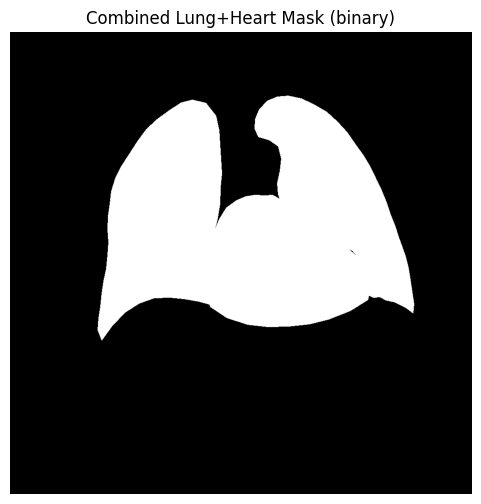

In [123]:
masker = ApplyLungCrop()
row = mask_df.iloc[200]
mask = compute_cropped_entry(row, masker)

# 2. Plot it
plt.figure(figsize=(6,6))
plt.imshow(mask, cmap="gray", vmin=0, vmax=1)
plt.title("Combined Lung+Heart Mask (binary)")
plt.axis("off")
plt.show()

In [5]:
img = Image.open("//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/"+mask_df['Path'][200])

In [7]:
img.size[:2]

(2539, 3050)

In [125]:
img = img.resize((1024,1024))

In [131]:
rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)


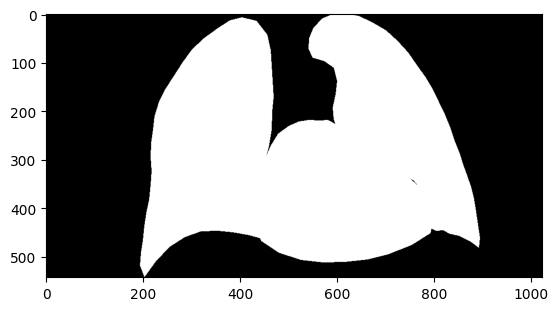

In [132]:
plt.imshow(mask[rows], cmap='gray')
plt.show()

In [134]:
rmin, rmax = np.where(rows)[0][[0, -1]]
cmin, cmax = np.where(cols)[0][[0, -1]]


In [135]:
cropped = img[rmin:rmax+1, cmin:cmax+1]


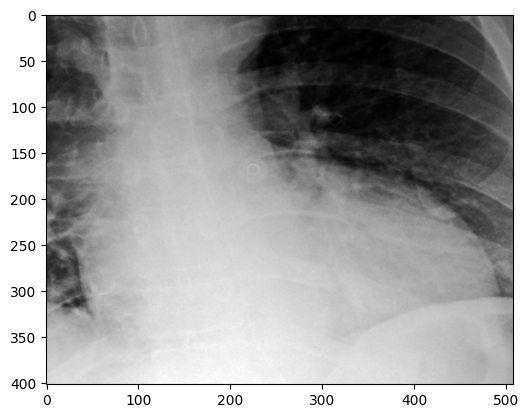

In [137]:
plt.imshow(cropped, cmap='gray')
plt.show()

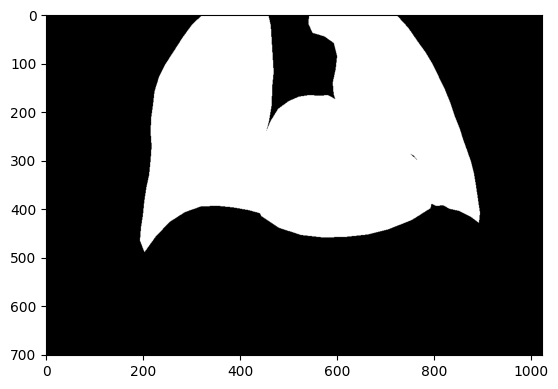

In [133]:
plt.imshow(mask[cols], cmap='gray')
plt.show()

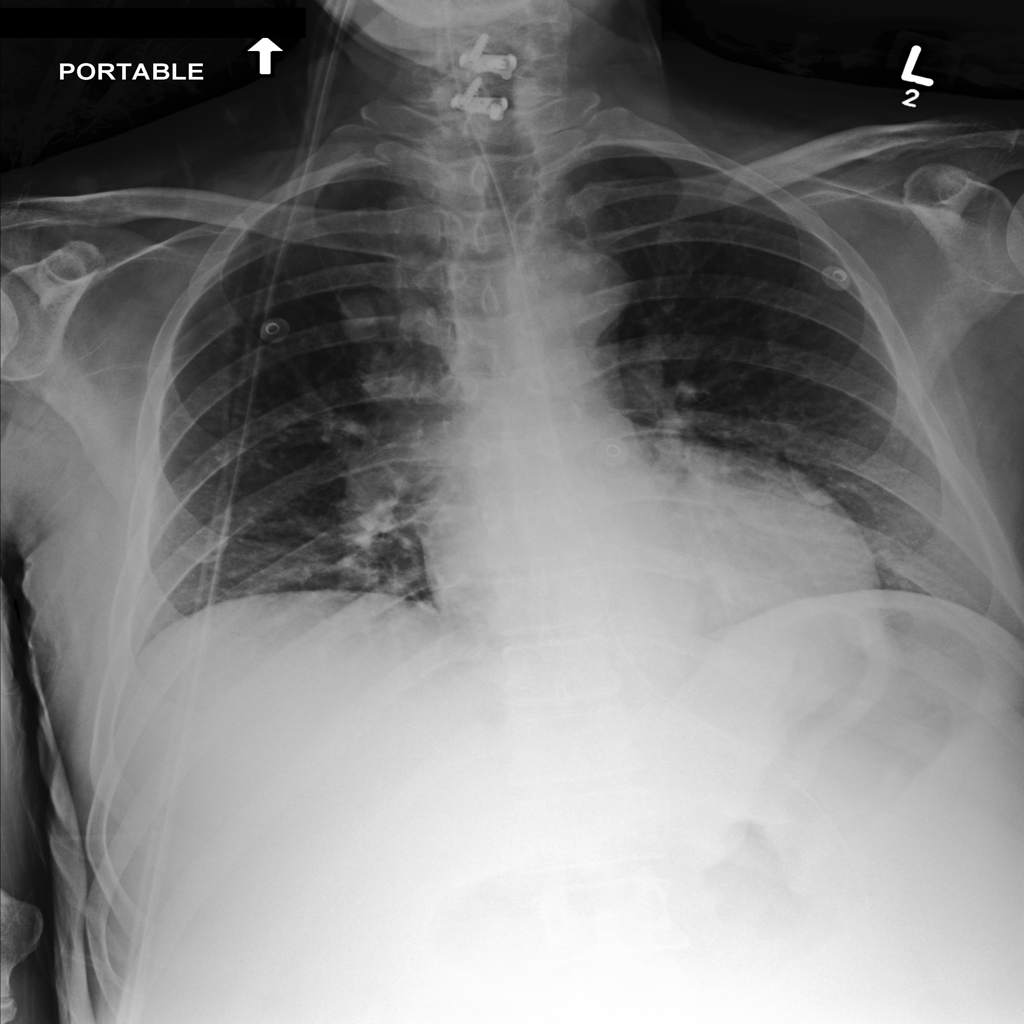

In [126]:
img

In [127]:
img = crop_image_to_mask(np.array(img), mask)

In [128]:
new_shape = cv2.resize(img, (224,224))

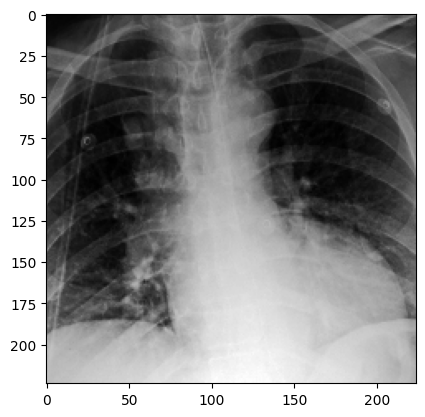

In [129]:
plt.imshow(new_shape, cmap='gray')
plt.show()

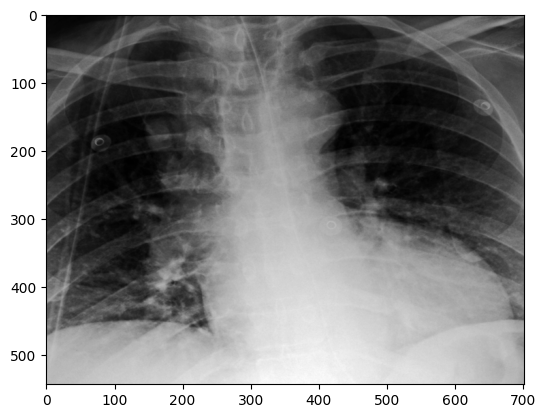

In [130]:
plt.imshow(img, cmap='gray')
plt.show()

In [79]:
from torchvision import transforms
transform = transforms.Compose(
        [   
            transforms.ToTensor(),
            transforms.Resize(
                (224, 224), interpolation=transforms.InterpolationMode.BICUBIC
            ),
            transforms.Lambda(lambda i: i.repeat(3, 1, 1) if i.shape[0] == 1 else i),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(0.3),
            transforms.RandomRotation(degrees=10),
        ]
    )

In [98]:
ts_img = transform(cl_img)

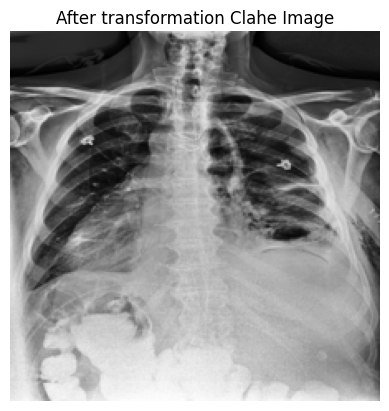

In [99]:
plt.imshow(ts_img[0], cmap='gray')
plt.axis('off')
plt.title('After transformation Clahe Image')
plt.show()

In [91]:
resize_img = cv2.resize(img, (224,224))

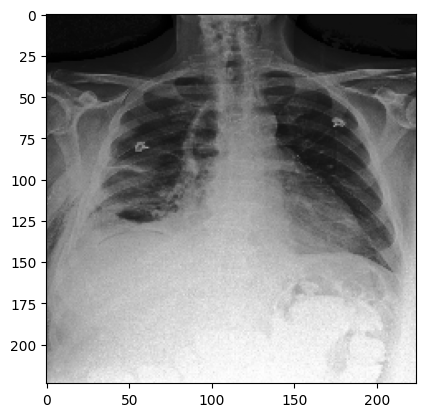

In [83]:
plt.imshow(resize_img, cmap='gray')
plt.show()

In [84]:
clahe_resize_img = create_clahe.apply(resize_img)

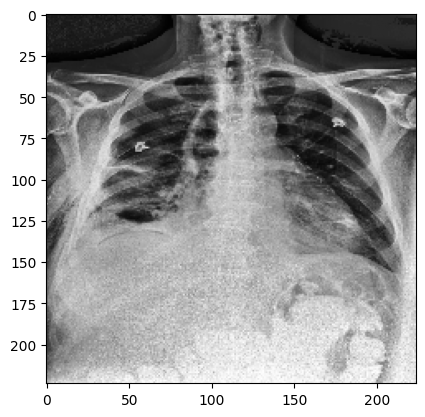

In [85]:
plt.imshow(clahe_resize_img, cmap='gray')
plt.show()

In [86]:
clahe_ts_img = transform(clahe_resize_img)

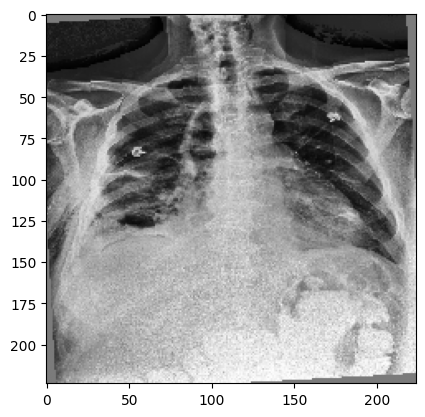

In [87]:
plt.imshow(clahe_ts_img[0], cmap='gray')
plt.show()

In [ ]:
import torchvision

class DenseNet_Model(nn.Module):
     def __init__(self, weights, out_feature):
          super().__init__()
          self.weight = weights
          self.out_feature = out_feature
          self.encoder = torchvision.models.densenet121(weights=weights) # Adapt the architecture to initial paper: The limits of fair medical imaging and almost all other papers
          self.relu = nn.ReLU()
          self.clf = nn.Linear(1000, out_feature)

     def encode(self, x):
          return self.encoder(x)

     def forward(self, x):
          z = self.encode(x)
          z = self.relu(z)
          return self.clf(z)

     def predict_proba(self, x):
          return torch.sigmoid(self(x))

In [7]:
model = DenseNet_Model(None, 11)

In [ ]:
gcam = gradcam(model, model.encoder)

TypeError: DenseNet_Model.encode() missing 1 required positional argument: 'x'

In [4]:
from collections import Counter

In [ ]:
race_counts = Counter([sample['race'] for sample in dataset])
total_race = sum(race_counts.values())

race_weights = {r: total_race / c for r, c in race_counts.items()}

TypeError: string indices must be integers, not 'str'

In [19]:
total_race = sum(dataset['race'].value_counts())

In [20]:
total_race

34532

In [16]:
dataset['race'].value_counts().index[:5]

Index(['WHITE', 'BLACK', 'OTHER', 'UNKNOWN', 'ASIAN'], dtype='object', name='race')

In [18]:
top_races = dataset["race"].value_counts().index[:5]
dataset = dataset[dataset["race"].isin(top_races)].copy()

In [27]:
race_weights = {r: total_race / c for r, c in dataset['race'].value_counts().items()}

In [36]:
labels = [
        "No Finding",
        "Enlarged Cardiomediastinum",
        "Cardiomegaly",
        "Lung Opacity",
        "Lung Lesion",
        "Edema",
        "Consolidation",
        "Pneumonia",
        "Atelectasis",
        "Pneumothorax",
        "Pleural Effusion"]

In [37]:
total_sample = len(dataset)

In [43]:
race_counts = dataset['race'].value_counts().to_dict()
total = sum(race_counts.values())

# Option 1: Inverse frequency
race_weights = {race: total / count for race, count in race_counts.items()}

In [44]:
race_weights

{'WHITE': 1.3840480961923847,
 'BLACK': 5.686151819529063,
 'OTHER': 27.233438485804417,
 'UNKNOWN': 28.824707846410686,
 'ASIAN': 33.10834132310642}

In [46]:
dataset['sample_weight'] = dataset['race'].map(race_weights)

In [48]:
import torch
from torch.utils.data import WeightedRandomSampler, DataLoader

sample_weights = dataset['sample_weight'].values
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)


In [49]:
sample_weights

array([ 1.3840481 ,  1.3840481 ,  1.3840481 , ...,  1.3840481 ,
        1.3840481 , 28.82470785], shape=(34532,))

In [29]:
race_weights['OTHER'] = 1
race_weights['UNKNOWN'] = 1

In [30]:
race_weights

{'WHITE': 1.3840480961923847,
 'BLACK': 5.686151819529063,
 'OTHER': 1,
 'UNKNOWN': 1,
 'ASIAN': 33.10834132310642}

In [2]:
from data_preprocessing.process_dataset import (
    add_demographic_data,
    add_lung_mask_dataset,
    add_metadata,
    cleaning_datasets,
    get_group_by_data,
    merge_file_path_and_add_dicom_id,
    sampling_datasets,
)

In [ ]:
total_data_merge = add_demographic_data('//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/mimic-cxr-2.0.0-chexpert.csv.gz' ,'//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/admissions.csv.gz')
total_data_merge = add_metadata(total_data_merge, '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/mimic-cxr-2.0.0-metadata.csv.gz')
total_data_clean = cleaning_datasets(total_data_merge, False)
sampling_total_dataset = sampling_datasets(total_data_clean)

In [4]:
sampling_total_dataset['race'].value_counts()

race
WHITE                         26645
BLACK                          6757
unknown/other                  3262
hisp/lat/SA                    2654
ASIAN                          1437
native                          148
UNABLE TO OBTAIN                138
PATIENT DECLINED TO ANSWER       87
MULTIPLE RACE/ETHNICITY          37
Name: count, dtype: int64

In [ ]:
dataset.loc[dataset.race.isin([
    "NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER",
    "AMERICAN INDIAN/ALASKA NATIVE"]),
    "race"] = "native"

dataset.loc[dataset.race.isin([
    "HISPANIC OR LATINO",
    "HISPANIC/LATINO - PUERTO RICAN",
    "HISPANIC/LATINO - GUATEMALAN",
    "HISPANIC/LATINO - HONDURAN",
    "HISPANIC/LATINO - COLUMBIAN",
    "HISPANIC/LATINO - DOMINICAN",
    "HISPANIC/LATINO - SALVADORAN",
    "HISPANIC/LATINO - CENTRAL AMERICAN",
    "HISPANIC/LATINO - CUBAN",
    "HISPANIC/LATINO - MEXICAN",
    "PORTUGUESE",
    "SOUTH AMERICAN"]),
    "race"] = "hisp/lat/SA"

dataset.loc[dataset.race.isin([
    "UNKNOWN",
    "OTHER"]),
    "race"] = "unknown/other"


In [5]:
dataset['race'].value_counts()

race
WHITE            24952
BLACK             6063
unknown/other     3019
hisp/lat/SA       2192
ASIAN             1045
native             137
Name: count, dtype: int64

In [8]:
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image

def plot_original_and_masked_images(normal_loader, masked_loader, num_images=100):
    images_shown = 0
    fig, axes = plt.subplots(num_images, 2, figsize=(6, num_images * 2.5))
    fig.suptitle("Original vs Masked Images", fontsize=20)

    for (orig_batch, _), (masked_batch, _) in zip(normal_loader, masked_loader):
        batch_size = orig_batch.size(0)
        for i in range(batch_size):
            if images_shown >= num_images:
                break

            orig_img = orig_batch[i]
            masked_img = masked_batch[i]

            orig_img_np = orig_img.permute(1, 2, 0).numpy()
            masked_img_np = orig_img.permute(1, 2, 0).numpy()

            axes[images_shown, 0].imshow(orig_img_np, cmap='gray')
            axes[images_shown, 0].axis("off")
            axes[images_shown, 0].set_title("Original")

            axes[images_shown, 1].imshow(masked_img_np, cmap='gray')
            axes[images_shown, 1].axis("off")
            axes[images_shown, 1].set_title("Masked")

            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


In [9]:
import multiprocessing
import os
from typing import Optional, Tuple, Union, Dict

import numpy as np
import pandas as pd
import torch
from joblib import Parallel, delayed
from PIL import Image
from scipy.ndimage import binary_dilation
from skimage.morphology import disk
import cv2
from torch.utils.data import Dataset
from tqdm import tqdm
import torchvision
from torch.utils.data import DataLoader

def decode_rle_numpy(rle_str: Optional[str], shape: Tuple[int, int]) -> np.ndarray:
    if pd.isna(rle_str) or not isinstance(rle_str, str):
        return np.zeros(shape, dtype=np.uint8)

    rle = np.fromiter(map(int, rle_str.strip().split()), dtype=np.int32)
    starts = rle[0::2] - 1  
    lengths = rle[1::2]

    mask = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        mask[start:start+length] = 1
    return mask.reshape((shape[1], shape[0])).T

class ApplyLungMask:
    def __init__(
        self,
        margin_radius: int = 20,
        original_shape: Tuple[int, int] = (1024, 1024),
        image_shape: Tuple[int, int] = (224, 224),
    ):
        self.margin_radius = margin_radius
        self.original_shape = original_shape
        self.image_shape = image_shape

    def dilate_mask(self, mask: np.ndarray) -> np.ndarray:
        selem = disk(self.margin_radius)
        return binary_dilation(mask, structure=selem).astype(np.uint8)

    def resize_mask(self, mask: np.ndarray) -> np.ndarray:
        resized = cv2.resize(mask, (self.image_shape[1], self.image_shape[0]), interpolation=cv2.INTER_NEAREST)
        return resized.astype(np.uint8)

    def compute_combined_mask(
        self, left_rle: Optional[str], right_rle: Optional[str], heart_rle: Optional[str]
    ) -> np.ndarray:
        left = self.dilate_mask(decode_rle_numpy(left_rle, self.original_shape))
        right = self.dilate_mask(decode_rle_numpy(right_rle, self.original_shape))
        heart = self.dilate_mask(decode_rle_numpy(heart_rle, self.original_shape))
        combined = np.clip(left + right + heart, 0, 1)
        return self.resize_mask(combined)

def compute_mask_entry(row: pd.Series, masker: ApplyLungMask) -> Tuple[str, np.ndarray]:
    key = row["Path"]
    mask = masker.compute_combined_mask(row["Left Lung"], row["Right Lung"], row["Heart"])
    return key, mask.astype(np.uint8)

class MyDataset(Dataset):
    def __init__(
        self,
        image_paths: Union[list, pd.Series],
        labels: Union[list, np.ndarray, pd.Series],
        dataframe: pd.DataFrame,
        masked: bool = False,
        transform: torchvision.transforms.Compose = None,
        base_dir: Optional[str] = None,
        is_multilabel: bool = True,
    ):
        self.image_paths = list(image_paths)
        self.labels = labels
        self.masked = masked
        self.df = dataframe.reset_index(drop=True)
        self.base_dir = base_dir
        self.transform = transform
        self.is_multilabel = is_multilabel
        self.masker = ApplyLungMask(margin_radius=60, original_shape=(1024, 1024), image_shape=(224, 224))
        self.mask_cache: Dict[str, np.ndarray] = {}

        if self.masked:
            rows = [row for _, row in self.df.iterrows()] 
            results = Parallel(n_jobs=multiprocessing.cpu_count(), backend='loky')(
                delayed(compute_mask_entry)(row, self.masker) for row in tqdm(rows)
            )
            self.mask_cache = dict(results)

    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        file_path = self.image_paths[idx]
        full_path = os.path.join(self.base_dir, file_path) if self.base_dir else file_path

        image = Image.open(full_path).convert("L").resize((224, 224))

        if self.masked:
            image_np = np.array(image)
            mask = self.mask_cache[file_path]
            masked_image_np = image_np * mask
            image = Image.fromarray(masked_image_np.astype(np.uint8))

        if self.transform:
            image = self.transform(image)

        if self.is_multilabel:
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
        else:
            label = torch.tensor(self.labels[idx], dtype=torch.long)

        return image, label

def prepare_mimic_dataloaders(
    images_path: Union[pd.Series, list, str],
    labels: Union[pd.Series, list, None],
    dataframe: pd.DataFrame,
    masked: bool,
    base_dir: Optional[str] = None,
    shuffle: bool = False,
    is_multilabel: bool = True,
) -> DataLoader:
    transform = transforms.Compose(
        [   
            # CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
            transforms.ToTensor(),
            transforms.Resize(
                (224, 224), interpolation=transforms.InterpolationMode.BICUBIC
            ),
            transforms.Lambda(lambda i: i.repeat(3, 1, 1) if i.shape[0] == 1 else i),
            transforms.Normalize(mean=[0.5062] * 3, std=[0.2873] * 3),
            transforms.RandomResizedCrop(
                (200, 200),
                scale=(0.9, 1.0),
                ratio=(0.9, 1.1),
                interpolation=transforms.InterpolationMode.BICUBIC,
            ),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(0.3),
            transforms.RandomRotation(degrees=10),
        ]
    )
    dataset = MyDataset(
        images_path,
        labels,
        dataframe,
        masked,
        transform,
        base_dir,
        is_multilabel=is_multilabel,
    )
    data_loader = DataLoader(
        dataset, batch_size=4, shuffle=shuffle, num_workers=12, pin_memory=True
    )

    return data_loader

In [10]:
dataset = dataset.iloc[:4]

In [ ]:
from torch.utils.data import DataLoader

# Shared arguments
common_args = {
    "Path": dataset['Path'],
    "labels": None,
    "dataset": dataset,
    "base_dir": '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/',
    "is_multilabel": True
}

# Create both datasets
masked_dataset = MyDataset(
        dataset['Path'],
        None,
        dataset,
        True,
        True,
        '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/',
        is_multilabel=False,
    )
masked_loader = DataLoader(masked_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
normal_dataset = MyDataset(
        dataset['Path'],
        None,
        dataset,
        False,
        True,
        '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/',
        is_multilabel=False,
    )
normal_loader = DataLoader(normal_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)



# Plot
plot_original_and_masked_images(normal_loader, masked_loader, num_images=4)


100%|██████████| 4/4 [00:00<00:00, 111.50it/s]
c:\Users\sutariya\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
import cv2
import numpy as np
from PIL import Image
import torchvision.transforms as transforms

class CLAHETransform:
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, img):
        # Convert PIL image to NumPy array
        img_np = np.array(img)

        # If grayscale, apply CLAHE directly
        if len(img_np.shape) == 2:
            img_np = self.clahe.apply(img_np)
        # If RGB, convert to LAB, apply CLAHE on L channel
        elif len(img_np.shape) == 3 and img_np.shape[2] == 3:
            lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
            lab[..., 0] = self.clahe.apply(lab[..., 0])
            img_np = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

        # Convert back to PIL image
        return Image.fromarray(img_np)


In [23]:
transform = transforms.Compose([
    CLAHETransform(),  # Apply CLAHE first
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomResizedCrop(
        (200, 200),
        scale=(0.9, 1.0),
        ratio=(0.9, 1.1),
        interpolation=transforms.InterpolationMode.BICUBIC,
    ),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(degrees=10),
])


In [24]:
import pandas as pd

In [25]:
train_data = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\main\mimic\dataset\validation_clean_dataset.csv")

In [26]:
img_pth = '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/'+ train_data['Path'][2]

In [27]:
img = cv2.imread(img_pth, cv2.IMREAD_GRAYSCALE)

In [28]:
img_clahe = transform(img)

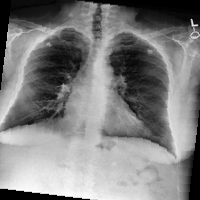

In [ ]:
img_clahe

In [33]:
cv2.imshow("Original Grayscale", img)

# Step 4: Wait for key press and close windows
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load image in grayscale
image = cv2.imread('//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/'+data['file_path'][1], cv2.IMREAD_GRAYSCALE)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))
clahe_image = clahe.apply(image)

# Plot original and CLAHE-enhanced image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("CLAHE Image")
plt.imshow(clahe_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image in grayscale
image = cv2.imread('//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/'+data['file_path'][1], cv2.IMREAD_GRAYSCALE)

# Convert to float32 for precision
image_float = image.astype(np.float32)

# Compute mean and std per image
mean = np.mean(image_float)
std = np.std(image_float)

# Avoid division by zero
if std == 0:
    std = 1e-8

# Normalize to zero mean and unit variance
normalized_image = (image_float - mean) / std


# Plot original and normalized image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Normaliza Image")
plt.imshow(normalized_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']


In [ ]:
class ApplyLungMask:
    def __init__(self, left_rle, right_rle, heart_rle, margin_radius=20, original_shape=(1024, 1024), image_shape=(512, 512)):
        self.left_rle = left_rle
        self.right_rle = right_rle
        self.heart_rle = heart_rle
        self.margin_radius = margin_radius
        self.original_shape = original_shape
        self.image_shape = image_shape

    def decode_rle(self, rle_str):
        if isinstance(rle_str, pd.Series):
            rle_str = rle_str.iloc[0]
        if pd.isna(rle_str):
            return np.zeros(self.original_shape, dtype=np.uint8)

        s = np.fromiter(map(int, rle_str.strip().split()), dtype=np.int32)
        starts = s[0::2] - 1  # 1-based indexing
        lengths = s[1::2]
        ends = starts + lengths

        mask = np.zeros(self.original_shape[0] * self.original_shape[1], dtype=np.uint8)

        # Efficient fill using advanced indexing
        for start, end in zip(starts, ends):
            mask[start:end] = 1

        return mask.reshape(self.original_shape)


    def dilate_mask(self, mask):
        selem = disk(self.margin_radius)
        return binary_dilation(mask, structure=selem).astype(np.uint8)

    def resize_mask(self, mask):
        mask_img = Image.fromarray(mask.astype(np.uint8) * 255)
        mask_resized = mask_img.resize((self.image_shape[1], self.image_shape[0]), resample=Image.NEAREST)
        return np.array(mask_resized) // 255

    def __call__(self, image):
        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)

        image_resized = image.resize(self.image_shape[::-1], Image.BILINEAR)
        image_np = np.array(image_resized)

        left_mask = self.decode_rle(self.left_rle)
        right_mask = self.decode_rle(self.right_rle)
        heart_mask = self.decode_rle(self.heart_rle)
        

        left_mask = self.dilate_mask(left_mask)
        right_mask = self.dilate_mask(right_mask)
        heart_mask = self.dilate_mask(heart_mask)

        combined_mask = left_mask + right_mask + heart_mask
        combined_mask = np.clip(combined_mask, 0, 1)

        combined_mask = self.resize_mask(combined_mask)
        masked_image = image_np * combined_mask

        return Image.fromarray(masked_image.astype(np.uint8))

        

In [ ]:
data = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\main\mimic\dataset\train_mask_clean_dataset.csv")

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

# Select 10 random rows
sampled_data = data.sample(n=10, random_state=42).reset_index(drop=True)

# Plotting setup
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(12, 40))
fig.suptitle("Original Image | Mask | Mask with Margin", fontsize=16, y=1.02)

for i, row in sampled_data.iterrows():
    try:
        # Load image
        path = os.path.join('//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/', row['file_path'])
        image = Image.open(path).convert('L')

        # Generate masks
        left_rle = row['Left Lung']
        right_rle = row['Right Lung']
        heart_rle = row['Heart']
        masker_margin = ApplyLungMask(left_rle, right_rle, heart_rle, margin_radius=50)
        masker_nomargin = ApplyLungMask(left_rle, right_rle, heart_rle, margin_radius=0)

        mask_image = masker_nomargin(image)
        mask_margin_image = masker_margin(image)

        # Plot Original Image
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Plot Mask
        axes[i, 1].imshow(mask_image, cmap='gray')
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')

        # Plot Mask with Margin
        axes[i, 2].imshow(mask_margin_image, cmap='gray')
        axes[i, 2].set_title('Mask with Margin')
        axes[i, 2].axis('off')

    except Exception as e:
        print(f"Error loading image {row['file_path']}: {e}")

plt.tight_layout()
plt.show()


In [ ]:
df_paths = pd.DataFrame(data, columns=['subject_id', 'study_id'])

In [ ]:
df_paths['study_id'].astype('int32')

In [ ]:
df_paths['subject_id'].astype(str)

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from PIL import Image
import os
import numpy as np

# Define your data transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a standard size (e.g., 224x224)
    transforms.ToTensor(),          # Convert image to a PyTorch tensor
])

# Path to your MIMIC-CXR-JPG dataset
dataset_dir = '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/'

# Collect all the image file paths
image_paths = [os.path.join(dataset_dir, fname) for fname in merge if fname.endswith('.jpg')]

# Initialize lists to collect pixel values
all_pixels = []

# Load images and collect pixel data
for img_path in image_paths:
    img = Image.open(img_path).convert('L')
    img = transform(img)  # Apply the transformations
    all_pixels.append(img)

# Convert all collected pixel data into a single tensor
all_pixels = torch.stack(all_pixels)

# Compute the mean and std
mean = torch.mean(all_pixels, dim=(0, 2, 3))  # Mean across batch, height, and width
std = torch.std(all_pixels, dim=(0, 2, 3))    # Std across batch, height, and width

print("Mean:", mean)
print("Standard Deviation:", std)


In [ ]:
data

In [ ]:
import pandas as pd

chunksize = 10000
all_mask_data = []

file_path = r"\\gaia\imageData\deep_learning\input\data\chexmask\chexmask-database-a-large-scale-dataset-of-anatomical-segmentation-masks-for-chest-x-ray-images-1.0.0\Preprocessed\MIMIC-CXR-JPG.csv"

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    all_mask_data.extend(chunk[['dicom_id', 'Left Lung', 'Right Lung', 'Landmarks']].to_dict('records'))


In [ ]:
mask_df = pd.DataFrame(all_mask_data)

In [ ]:
file_path = r"\\gaia\imageData\deep_learning\input\data\chexmask\chexmask-database-a-large-scale-dataset-of-anatomical-segmentation-masks-for-chest-x-ray-images-1.0.0\Preprocessed\MIMIC-CXR-JPG.csv"
chunksize = 1000
for chunk in pd.read_csv(file_path, chunksize=chunksize):
    mask_data = chunk
    break


In [ ]:
mask_data['Landmarks']

In [ ]:
data['file_path'].str.split('/')

In [ ]:
dicom_id = []
for path in data['file_path'].str.split('/'):
     dicom_id.append(path[-1][:-4])

In [ ]:
dicom_df = pd.DataFrame(dicom_id)

In [ ]:
new_data = pd.concat([data, dicom_df], axis=1)

In [ ]:
new_data.rename(columns={0:'dicom_id'}, inplace=True)

In [ ]:
mask_df

In [ ]:
mask_dicom_id = mask_df[mask_df['dicom_id'].isin(dicom_id)]['dicom_id']

In [ ]:
mask_contain_datset = new_data[new_data['dicom_id'].isin(mask_dicom_id)]

In [ ]:
merge_mask_dataset = pd.merge(mask_contain_datset, mask_df, how='inner', on='dicom_id')

In [ ]:
merge_mask_dataset.columns

In [ ]:

import cv2
import numpy as np
from scipy.ndimage import binary_dilation
from skimage.morphology import disk
import matplotlib.pyplot as plt
from PIL import Image

def decode_rle(rle_str, shape=(1024, 1024)):
    """
    Decode RLE string to binary mask.
    """
    s = list(map(int, rle_str.strip().split()))
    starts, lengths = s[0::2], s[1::2]
    flat_mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        flat_mask[start:start + length] = 1
    return flat_mask.reshape(shape)


def dilate_mask(mask, margin_radius):
    selem = disk(margin_radius)
    return binary_dilation(mask, structure=selem).astype(np.uint8)

def resize_mask(mask, new_shape):
    """
    Resize mask using nearest neighbor (no interpolation).
    """
    mask_img = Image.fromarray(mask.astype(np.uint8) * 255)
    mask_resized = mask_img.resize((new_shape[1], new_shape[0]), resample=Image.NEAREST)
    return np.array(mask_resized) // 255  # back to binary


def rescale_landmarks(landmarks, from_shape, to_shape):
    """
    Rescale landmark coordinates from one image shape to another.
    """
    scale_x = to_shape[1] / from_shape[1]
    scale_y = to_shape[0] / from_shape[0]
    return [(int(x * scale_x), int(y * scale_y)) for x, y in landmarks]



def parse_landmarks(landmark_str):
    try:
        coords = list(map(int, landmark_str.strip().split(',')))
        if len(coords) % 2 != 0:
            raise ValueError("Uneven number of coordinates in landmark string")
        landmarks = [(coords[i], coords[i + 1]) for i in range(0, len(coords), 2)]
        return landmarks
    except Exception as e:
        print("Failed to parse landmarks:", e)
        return []



mask_df = data
row = mask_df.iloc[11]

# === Step 3: Load image ===
image_path = '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/' + row['file_path']
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
print(image.shape)
h, w = image.shape
original_shape = (1024, 1024)
actual_shape = image.shape 

left_mask = decode_rle(row['Left Lung'], shape=(1024, 1024))
right_mask = decode_rle(row['Right Lung'], shape=(1024, 1024))

left_mask_dilated = dilate_mask(left_mask, 60)   # smaller margin
right_mask_dilated = dilate_mask(right_mask, 60) # bigger margin

mask_combined = np.clip(left_mask_dilated + right_mask_dilated, 0, 1)
mask_resized = resize_mask(mask_combined, image.shape)
masked_image = image * mask_resized

# Apply the mask to image
masked_image = image * mask_resized


# Plot everything
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image with Landmarks")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Masked Image (Lungs)")
plt.imshow(masked_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import copy
import os
import matplotlib.pyplot as plt
import cv2

In [ ]:

from torch.utils.data import Dataset, DataLoader, random_split
import os
from torchvision import transforms
import torch
from PIL import Image
        
class MyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, base_dir='//gaia/imageData/deep_learning/output/Sutariya/chexpert/'):
        self.image_paths = list(image_paths)
        self.labels = labels
        self.transform = transform
        self.base_dir = base_dir

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = os.path.join(self.base_dir, self.image_paths[idx])
        image = Image.open(path)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32) 
        return image, label


def prepare_dataloaders(image_paths, labels, shuffle=False):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Lambda(lambda i: i.repeat(3, 1, 1) if i.shape[0] == 1 else i),
        transforms.Lambda(lambda i: i/255),
        transforms.Normalize(mean=[0.5062, 0.5062, 0.5062], std=[0.2873, 0.2873, 0.2873]), # Adapt to own standard deviation and mean to Chexpert
        transforms.Lambda(lambda i: i.to(torch.float32)),
        transforms.RandomResizedCrop((224,224), scale=(0.6, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(contrast=(0.7, 1.2)) # Randomly change the brightness, contrast, saturation and hue of an image
    ])

    dataset = MyDataset(image_paths, labels, transform)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=shuffle, num_workers=4, pin_memory=True)

    return data_loader

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC), 
    transforms.ToTensor(),
    transforms.Lambda(lambda i: i.repeat(3, 1, 1) if i.shape[0] == 1 else i),
    transforms.Normalize(mean=[0.5062]*3, std=[0.2873]*3),
    transforms.RandomResizedCrop(
        (200, 200),
        scale=(0.9, 1.0),               
        ratio=(0.9, 1.1),              
        interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(0.3),
    transforms.RandomRotation(degrees=10)
    ])

In [ ]:
training_dataset_chexpert = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\chexpert\train_clean_dataset.csv") 

In [ ]:
labels = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']
data = MyDataset(training_dataset_chexpert['Path'], training_dataset_chexpert[labels].values, transform=transform)

In [ ]:
data1 = MyDataset(training_dataset_chexpert['Path'], training_dataset_chexpert[labels].values)

In [ ]:
img, lbl = data.__getitem__(666)

In [ ]:
img1, lbl1 = data1.__getitem__(666)

In [ ]:
img.shape

In [ ]:
img1

In [ ]:
plt.imshow(img1, cmap='gray')
plt.show()

In [ ]:
plt.imshow(img[0],cmap='gray')
plt.show()

In [ ]:
img.shape

In [ ]:
data.labels[0]

In [ ]:
for img, label in train_loader:
     print(img, label)
     break

In [ ]:
training_dataset_chexpert['Pneumonia']

In [ ]:
print(path)

In [ ]:
valid = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\chexpert\valid.csv")

In [ ]:
def select_most_positive_sample(group):

    disease_columns = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture'
    ]
    
    group['positive_count'] = group[disease_columns].sum(axis=1)
    
    positive_cases = group[group['positive_count'] > 0]
    
    if not positive_cases.empty:

        selected_sample = positive_cases.loc[positive_cases['positive_count'].idxmax()]
    else:
        selected_sample = group.sample(n=1).iloc[0]
    
    return selected_sample


# Select the single subject_id per patient which has most positive disease 
def sampling_datasets(training_dataset):

    training_dataset = training_dataset.groupby('subject_id', group_keys=False).apply(select_most_positive_sample)
    training_dataset.drop(columns=['positive_count'], inplace=True, errors='ignore')
    
    return training_dataset


def cleaning_datasets(traning_dataset):

    traning_dataset[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']] = (traning_dataset[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']].fillna(0.0) == 1.0).astype(int)  # In The limits of fair medical imaging paper they treat uncertain label as negative and fill NA with 0.

    #Select only Frontal View 
    traning_dataset = traning_dataset[traning_dataset['Frontal/Lateral'] == 'Frontal']

    return traning_dataset


In [ ]:
def merge_dataframe(training_data, demographic_data):
    path = training_data['Path']
    patientid = []
    for i in path:
        id = i.split(sep='/')[2]
        id = id.replace("patient", "")
        patientid.append(float(id))

    temp_patient = pd.DataFrame(patientid,columns=['patient_id'])
    training_data = training_data.reset_index(drop=True)
    training_data['subject_id'] = temp_patient['patient_id']
    training_data_merge = training_data.merge(demographic_data, on='subject_id')
    return training_data_merge



In [ ]:
demo = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\chexpert\demographics_CXP.csv")

In [ ]:
merge_data = merge_dataframe(training_data, demo)

In [ ]:
clean_merge_data = cleaning_datasets(merge_data)

In [ ]:
sampling_merge_data = sampling_datasets(clean_merge_data)

In [ ]:
sampling_merge_data['']

In [ ]:
train_ethnic_group = sampling_merge_data.groupby('ethnicity')

In [ ]:
group_by_data = {}
for group, data in train_ethnic_group:
     group_by_data[group] = data

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

N = 60 
ethnicity_col = 'Ethnicity'
diseases = [
    "Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax", 'Support Devices'
]
ethnic_groups = ["Non-Hispanic/Non-Latino", "Hispanic/Latino"]

df = sampling_merge_data

# Helper to sample for test set
def sample_test(df_group, disease, n_samples=N):
    positives = df_group[df_group[disease] == 1]

    sampled_pos = positives.sample(n=n_samples, random_state=42)

    return sampled_pos

# Sample the test set
test_dfs = []

for ethnicity in ethnic_groups:
    df_ethnicity = group_by_data[ethnicity]
    
    for disease in diseases:
        sampled_test = sample_test(df_ethnicity, disease, N)
        test_dfs.append(sampled_test)

# Combine test samples
final_test_df = pd.concat(test_dfs).drop_duplicates().reset_index(drop=True)


# Save
final_test_df.to_csv('test_split.csv', index=False)

print("✅ Done! Test shape:", final_test_df.shape)


In [ ]:
test = pd.read_csv('test_split.csv')

In [ ]:
"Atelectasis", "Cardiomegaly", "Consolidation", "Edema",
    "Enlarged Cardiomediastinum", "Fracture", "Lung Lesion",
    "Lung Opacity", "No Finding", "Pleural Effusion", "Pleural Other",
    "Pneumonia", "Pneumothorax"

In [ ]:
test['Support Devices'].value_counts()

In [ ]:
test.to_csv('test_split.csv', index=False)

In [ ]:
test = pd.read_csv('test_split.csv')

In [ ]:
test['No Finding'].value_counts().values

In [ ]:
sample = test[test['Fracture'] == 1].sample(20)

In [ ]:
sample

In [ ]:
test[test['Fracture'] == 0]

In [ ]:

test[test['Fracture'] == 0].sample(10)

In [ ]:
sampling_merge_data.columns

In [ ]:
test.drop(['Sampled_Ethnicity', 'Sampled_Disease'], axis=1, inplace=True)

In [ ]:
test.columns

In [ ]:
group_by_data = {}
group_data = test.groupby('ethnicity')
for g, d in group_data:
     group_by_data[g] = d

In [ ]:

features = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]

feature_counts = []

for feature in features:
    counts = group_by_data['Non-Hispanic/Non-Latino'][feature].value_counts()
    for value, count in counts.items():
        feature_counts.append({
            'Feature': feature,
            'Value': value,
            'Count': count,
            'ratio': np.round(count / len(group_by_data['Non-Hispanic/Non-Latino']),2)
        })

summary_non_hispanic_df = pd.DataFrame(feature_counts)

summary_non_hispanic_df = summary_non_hispanic_df.sort_values(by=['Feature', 'Count']).reset_index(drop=True)



In [ ]:
summary_non_hispanic_df

In [ ]:
sampling_dataset = pd.read_csv(r"E:\Thesis\CXR_Preprocessing\cxr_preprocessing\sampling_data_merge.csv")

In [ ]:
sampling_dataset

In [ ]:
test = pd.read_csv(r'E:\Thesis\CXR_Preprocessing\cxr_preprocessing\test_split.csv')

In [ ]:
test['subject_id'].value_counts()

In [ ]:
traning_data = sampling_dataset[~sampling_dataset['subject_id'].isin(test['subject_id'])]

In [ ]:
traning_data

In [ ]:
len(sampling_dataset) - len(traning_data)

In [ ]:


features = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices'
]

feature_counts = []

for feature in features:
    counts = group_by_data['Hispanic/Latino'][feature].value_counts()
    for value, count in counts.items():
        feature_counts.append({
            'Feature': feature,
            'Value': value,
            'Count': count,
            'ratio': np.round(count / len(group_by_data['Hispanic/Latino']),2)
        })

summary_hispanic_df = pd.DataFrame(feature_counts)

summary_hispanic_df = summary_hispanic_df.sort_values(by=['Feature', 'Count']).reset_index(drop=True)



In [ ]:
summary_hispanic_df

In [ ]:
summary_non_hispanic_df

In [ ]:
group_by_data['Non-Hispanic/Non-Latino'].value_counts(subset=[
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture'
    ])

In [ ]:
training_data_merge = pd.read_csv(r"E:\Thesis\CXR_Preprocessing\sampling_data_merge.csv")

In [ ]:
random_numbers = np.random.randint(len(training_data_merge['Path']), size=10)

In [ ]:
imgs = []
for i in range(len(random_numbers)):
     img = cv2.imread(r'..//..//datasets/' + str(training_data_merge['Path'][random_numbers[i]]), cv2.IMREAD_GRAYSCALE)
     imgs.append(img)

In [ ]:

for i in imgs:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    adaptive_img = clahe.apply(i)
    
    images = [i ,adaptive_img]
    titles = ['Original Image',  'Adaptive Hist']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  

    for i, image in enumerate(images):
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(titles[i])
        axes[i, 0].axis('off')

        axes[i, 1].hist(image.ravel(), bins=256)
        axes[i, 1].set_title('Histogram')

        axes[i, 2].hist(image.ravel(), bins=256, cumulative=True)
        axes[i, 2].set_title('Cumulative Distribution')


plt.tight_layout()
plt.show()


In [ ]:

for i in imgs:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    adaptive_img = clahe.apply(i)


    images = [i ,adaptive_img]
    titles = ['Original Image',  'Adaptive Hist']

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  

    for i, image in enumerate(images):
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title(titles[i])
        axes[i, 0].axis('off')

        axes[i, 1].hist(image.ravel(), bins=256)
        axes[i, 1].set_title('Histogram')

        axes[i, 2].hist(image.ravel(), bins=256, cumulative=True)
        axes[i, 2].set_title('Cumulative Distribution')


plt.tight_layout()
plt.show()


In [ ]:
eq_hist_img

In [ ]:
eq_hist_img = cv2.equalizeHist(resized_img)

In [ ]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
ada_hist_img = clahe.apply(resized_img)

In [ ]:

plt.figure(figsize=(15, 5))
# Plot original histogram and cumulative histogram
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')

plt.subplot(1, 2, 2)
plt.imshow(eq_hist_img, cmap='gray')


plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(img.ravel(), bins=255, range=(1,255))


plt.subplot(1, 2, 2)
plt.hist(eq_hist_img.ravel()*255, bins=255,  range=(1,255))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(ada_hist_img.ravel()*255, bins=255,  range=(1,255))


plt.subplot(1, 2, 2)
plt.imshow(ada_hist_img, cmap='gray')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(img.ravel(), bins=256, cumulative=True)
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(ada_hist_img.ravel(), bins=256, cumulative=True)


plt.subplot(1, 2, 2)
plt.hist(eq_hist_img.ravel(), bins=256, cumulative=True)
plt.show()


In [ ]:
mimic_dataset = pd.read_csv('../../mimic_cxr/mimic_cxr_jpg_with_demographics.csv')

In [ ]:
mimic_dataset

In [ ]:
def cleaning_datasets(traning_dataset):

    traning_dataset[['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']] = (traning_dataset[['Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']].fillna(0.0) == 1.0).astype(int) # In The limits of fair medical imaging paper they treat uncertain label as negative and fill NA with 0.

    return traning_dataset

In [ ]:
import pandas as pd

def select_most_positive_sample(group):
    disease_columns = [
        'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 
        'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 
        'Lung Opacity', 'No Finding', 'Pleural Effusion', 
        'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices'
    ]
    
    # Count positive cases
    group['positive_count'] = group[disease_columns].sum(axis=1)

    # Select cases with at least one positive disease
    positive_cases = group[group['positive_count'] > 0]
    
    if not positive_cases.empty:
        selected_sample = positive_cases.loc[[positive_cases['positive_count'].idxmax()]].copy()
    else:
        selected_sample = group.sample(n=1)

    return selected_sample

# Select one subject_id per patient with the most positive diseases
def sampling_datasets(training_dataset):
    training_dataset = training_dataset.groupby('subject_id', group_keys=False).apply(select_most_positive_sample)
    
    # Drop helper column
    training_dataset.drop(columns=['positive_count'], inplace=True, errors='ignore')

    return training_dataset


In [ ]:
mimic_dataset = cleaning_datasets(mimic_dataset)

In [ ]:

sampling_mimic_dataset = sampling_datasets(mimic_dataset)

In [ ]:
sampling_mimic_dataset

In [ ]:
mimic_dataset.columns

In [ ]:
patient_id, study_id = sampling_mimic_dataset['subject_id'], sampling_mimic_dataset['study_id']

In [ ]:
paths = []
with open('IMAGE_FILENAMES.txt', 'r') as f:
     paths = f.readlines()

In [ ]:
paths[0][0:-1]

In [ ]:
paths[0][:-1]

In [ ]:
clean_path = []
for i in paths:
     clean_path.append(i[:-1])

In [ ]:
clean_path

In [ ]:
paths[0][0:-1][11:19]

In [ ]:
paths[0][0:-1][21:29]

In [ ]:

data = []
for path in clean_path:
    
    patient_id = path[11:19]
    study_id = path[21:29]
    data.append((patient_id, study_id, path))

df_paths = pd.DataFrame(data, columns=['subject_id', 'study_id', 'file_path'])




In [ ]:
df_paths

In [ ]:
df_paths['subject_id'] = df_paths['subject_id'].astype(str)
df_paths['study_id'] = df_paths['study_id'].astype(str)

# Ensure mimic_dataset has the same data types
sampling_mimic_dataset['subject_id'] = sampling_mimic_dataset['subject_id'].astype(str)
sampling_mimic_dataset['study_id'] = sampling_mimic_dataset['study_id'].astype(str)

In [ ]:
merge_mimic_dataset = sampling_mimic_dataset.merge(df_paths, on=['subject_id', 'study_id'], how='left')

In [ ]:
merge_mimic_dataset

In [ ]:
merge_mimic_dataset.drop_duplicates(subset=['subject_id', 'study_id'], inplace=True)


In [ ]:
img = '//gaia/imageData/public/MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0' + str(merge_mimic_dataset['file_path'][0])

In [ ]:
img

In [ ]:
plt.imread(img)

In [ ]:
img, img1, img2,img3 ,img4, img5,img6,img7,img8 = plt.imread(r"E:\Thesis\demo.jpg"),plt.imread(r"E:\Thesis\demo1.jpg"), plt.imread(r"E:\Thesis\demo (2).jpg"), plt.imread(r"E:\Thesis\demo (3).jpg"), plt.imread(r"E:\Thesis\demo (4).jpg"), plt.imread(r"E:\Thesis\demo (5).jpg"), plt.imread(r"E:\Thesis\demo (6).jpg"), plt.imread(r"E:\Thesis\demo (7).jpg"), plt.imread(r"E:\Thesis\demo (8).jpg")

In [ ]:
eq_img, eq_img1, eq_img2, eq_img3,eq_img4,eq_img5,eq_img6,eq_img7,eq_img8 = exposure.equalize_hist(img), exposure.equalize_hist(img1), exposure.equalize_hist(img2), exposure.equalize_hist(img3), exposure.equalize_hist(img4), exposure.equalize_hist(img5), exposure.equalize_hist(img6), exposure.equalize_hist(img7), exposure.equalize_hist(img8)

In [ ]:
images = [img, img1, img2, img3, img4, img5, img6, img7, img8]
equalized_images = [eq_img, eq_img1, eq_img2, eq_img3, eq_img4, eq_img5, eq_img6, eq_img7, eq_img8]


In [ ]:
def read_and_equalize(image_path):
    # Read image in grayscale
    original_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image to (224, 224)
    resized_img = cv2.resize(original_img, (224,224))
    
    # Exclude pixels with 0 value for processing
    img = resized_img[(resized_img > 0)]
    
    # Equalize the histogram of the image
    hist = exposure.equalize_hist(img,nbins=255)
    
    return resized_img, hist

# Paths for your 9 images
image_paths = [
    r"E:\Thesis\demo.jpg",
    r"E:\Thesis\demo1.jpg",
    r"E:\Thesis\demo (2).jpg",
    r"E:\Thesis\demo (3).jpg",
    r"E:\Thesis\demo (4).jpg",
    r"E:\Thesis\demo (5).jpg",
    r"E:\Thesis\demo (6).jpg",
    r"E:\Thesis\demo (7).jpg",
    r"E:\Thesis\demo (9).jpg"
]

# Prepare lists to store results
original_images = []
equalized_images = []

# Process each image
for path in image_paths:
    orig, eq = read_and_equalize(path)
    original_images.append(orig)
    equalized_images.append(eq)


In [ ]:
im, hist = read_and_equalize(r"C:\Users\sutariya\Downloads\IM-0035-0001.jpeg")

In [ ]:
eq_img = exposure.equalize_hist(im,nbins=255)

In [ ]:
eq_img

In [ ]:
plt.hist(im.ravel(), bins=255, range=(1,255))
plt.show()

In [ ]:
plt.imshow(im, cmap='gray')
plt.show()

In [ ]:
plt.imshow(eq_img, cmap='gray')
plt.show()

In [ ]:
plt.hist(eq_img.ravel()*255, bins=255, range=(1,255))
plt.show()

In [ ]:
for i in range(9):
    plt.figure(figsize=(15, 5))

    # Plot original histogram and cumulative histogram
    plt.subplot(1, 2, 1)
    plt.hist(equalized_images[i].ravel(), bins=255, range=(1,255))
    plt.title(f"Histogram of Original Image {i+1} (No 0s)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 2, 2)
    plt.hist(original_images[i].ravel(), bins=255, cumulative=True)
    plt.title(f"Cumulative Histogram of Original Image {i+1} (No 0s)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Cumulative Frequency")

    # Plot equalized histogram and cumulative histogram
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.hist(equalized_images[i].ravel(), bins=255, range=(1,255))
    plt.title(f"Histogram of Equalized Image {i+1} (No 0s)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 2, 2)
    plt.hist(equalized_images[i].ravel(), bins=255, cumulative=True)
    plt.title(f"Cumulative Histogram of Equalized Image {i+1} (No 0s)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Cumulative Frequency")

    plt.tight_layout()
    plt.show()

In [ ]:
np.sqrt(equalized_images[0].shape[0])

In [ ]:
for i in range(9):
    plt.figure(figsize=(15, 5))

    # Plot original histogram and cumulative histogram
    plt.subplot(1, 2, 1)
    plt.imshow(original_images[i], cmap='gray')
    plt.title(f"Image {i}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(equalized_images[i],cmap='gray')
    plt.title(f"Eq_image {i}")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd

# Define file names
chexpert_file = "../../datasets/mimic-cxr-2.0.0-chexpert.csv"  # MIMIC-CXR metadata
patients_file = "../../datasets/admissions.csv"  # MIMIC-IV patient demographics
output_file = "mimic_cxr_jpg_with_demographics.csv"  # Merged output file

# Load the CSV files
df_chexpert = pd.read_csv(chexpert_file)
df_patients = pd.read_csv(patients_file)

# Check for duplicate subject_id in patients dataset
df_patients_unique = df_patients[['subject_id', 'race']].drop_duplicates(subset=['subject_id'])

# Verify uniqueness
assert df_patients_unique.duplicated(subset=['subject_id']).sum() == 0, "Duplicate subject_id found in patients dataset"

# Merge using 'subject_id' (left join to retain only rows in chexpert file)
df_merged = df_chexpert.merge(df_patients_unique, on="subject_id", how="left")

# Save the merged dataset
df_merged.to_csv(output_file, index=False)

# Display the number of rows before and after merging
print(f"Original dataset size: {df_chexpert.shape[0]}")
print(f"Merged dataset size: {df_merged.shape[0]}")
print(f"Merged dataset saved as: {output_file}")

# Display the first few rows
print(df_merged.head())

In [ ]:
df_merged = pd.read_csv('mimic_cxr_jpg_with_demographics.csv')

In [ ]:
df_merged['race']

In [ ]:
mimic_dataset['race'] = mimic_dataset['race'].dropna()

In [ ]:
mimic_dataset

In [ ]:
# Check for missing values
print(df_cleaned.isnull().sum())  # Shows missing values per column
print(df_cleaned.info())  # Checks data types
print(df_cleaned.head())  # Displays sample data


In [ ]:
df_cleaned = df_merged.dropna(subset=['race'])

In [ ]:
df_cleaned

In [ ]:

df_cleaned.to_csv("mimic_cxr_jpg_with_demographics.csv", index=False)


In [ ]:
training_data_merge = pd.read_csv('sampling_data_merge.csv')

In [ ]:
def get_histogram(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))
    img = img[(img > 0) & (img < 255)]
    hist = cv2.calcHist([img], [0], None, [254], [1, 255])
    return hist.flatten()

In [ ]:
import h5py
import numpy as np

hdf5_file = "histogram_count_data.h5"
batch_size = 3000

# Open HDF5 file for writing with variable-length data
with h5py.File(hdf5_file, 'w') as f:
    dt = h5py.vlen_dtype(np.int16)  # Variable-length data type
    f.create_dataset('hist', shape=(0,), maxshape=(None,), dtype=dt)

# Process and store amplitude spectra in batches
for i in range(0, len(training_data_merge), batch_size):
    batch_paths = training_data_merge['Path'][i:i + batch_size]

    # Compute amplitude spectra for batch
    batch_hist = [get_histogram(r'..//..//datasets/' + str(p)) for p in batch_paths]

    # Append batch to HDF5 file
    with h5py.File(hdf5_file, 'a') as f:
        current_size = f['hist'].shape[0]
        f['hist'].resize(current_size + len(batch_hist), axis=0)
        f['hist'][current_size:] = batch_hist

    print(f"Processed batch {i // batch_size + 1}/{(len(training_data_merge) // batch_size) + 1}")


In [ ]:
def save_files_by_race_group(file_path, output_dir, dataframe,  batch_size=1000, is_hist=True):
    race_labels = dataframe['race'].values
    race_dict = {}
    with h5py.File(file_path, 'r') as f:
        for i in range(0, len(dataframe), batch_size):
            batch_race_labels = race_labels[i:i + batch_size]
            batch_data = f['hist'][i:i + batch_size] if is_hist else f['amplitude_spectrum'][i:i + batch_size]
            for data, race in zip(batch_data, batch_race_labels):
                if race not in race_dict:
                    race_dict[race] = []
                race_dict[race].append(data)

    os.makedirs(output_dir, exist_ok=True)
    for race, data in race_dict.items():
        race_file = os.path.join(output_dir, f"{race}.h5")
        num_samples = len(data)
        feature_size = len(data[0])

        with h5py.File(race_file, 'w') as f:
            dset = f.create_dataset(
                "hist" if is_hist else "amplitude_spectrum",
                shape=(0, feature_size),
                maxshape=(None, feature_size),
                dtype= np.int16 if is_hist else np.float32,
                compression="gzip"
            )

            for i in range(0, num_samples, batch_size):
                batch = np.array(data[i : i + batch_size], dtype=np.int16 if is_hist else np.float32)
                dset.resize(dset.shape[0] + batch.shape[0], axis=0)
                dset[-batch.shape[0] :] = batch  
                print(f"Saved batch {i // batch_size + 1} for {race} ({dset.shape[0]} samples total)")

        print(f"{race} data saved in {race_file} (Total samples: {num_samples})")

    print("Race-wise data saved in files successfully!")
            

In [ ]:
def calculate_mean(h5_file_path, batch_size=2000, is_hist=True):
     mean = 0
     with h5py.File(h5_file_path, 'r') as f:
          num_samples = len(f['hist']) if is_hist else len(f['amplitude_spectrum'])
          if num_samples < batch_size:
               batch_size = num_samples
          num_batch = num_samples / batch_size
          for i in range(0, num_samples, batch_size):
               batch = np.array(f['hist'][i : i + batch_size], dtype=np.float32) if is_hist else np.array(f['amplitude_spectrum'][i : i + batch_size], dtype=np.float32)
               mean += np.mean(batch, axis=0)
     
     mean /= num_batch
     return mean
           

In [ ]:
def relative_difference(hist_A, hist_B):
    return (hist_B - hist_A) / (hist_A + 1e-6) 


In [ ]:
save_files_by_race_group('histogram_count_data.h5', 'histograms', training_data_merge)

In [ ]:
with h5py.File('histograms/Native American.h5', 'r') as f:
     hist = f['hist'][:]

In [ ]:
hist[0:10]

In [ ]:
for i in hist:
     print(i[0:6])

In [ ]:
hist.shape

In [ ]:
plt.plot(hist[10])
plt.show()

In [ ]:
for i in hist:
     print(i[251:256])

In [ ]:
asian_hist_mean = calculate_mean('histograms/Asian.h5')

In [ ]:
asian_hist_mean

In [ ]:
white_hist_mean = calculate_mean('histograms/White.h5')

In [ ]:
Asian_specific = calculate_mean('histograms/Pacific Islander.h5')

In [ ]:
other_hist_mean = calculate_mean('histograms/Other.h5')

In [ ]:
black_hist_mean = calculate_mean('histograms/Black.h5')

In [ ]:
diff = relative_difference(white_hist_mean, Asian_specific)

In [ ]:
native_american = calculate_mean('histograms/Native American.h5')

In [ ]:
diff = relative_difference(Asian_specific, unknown_mean)

In [ ]:
unknown_mean = calculate_mean('histograms/Unknown.h5')

In [ ]:
native_american

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(other_hist_mean, color='r', linewidth=2, alpha=0.4)
plt.plot(white_hist_mean, color='y', linewidth=2, alpha=0.4)
plt.plot(asian_hist_mean, color='g', linewidth=2, alpha=0.4)
plt.plot(black_hist_mean, color='b', linewidth=2, alpha=0.4)
plt.plot(native_american, color='purple', linewidth=2, alpha=0.4)
plt.plot(Asian_specific, color='brown', linewidth=2, alpha=0.4)
plt.plot(unknown_mean, color='white', linewidth=2, alpha=0.4)
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.title("Grayscale Histogram")
plt.grid()
plt.show()

In [ ]:
def plot_relative_difference(relative_diff, title="Relative Difference in Histograms"):
    plt.figure(figsize=(10, 5))
    plt.plot(relative_diff, label="Relative Difference")
    plt.axhline(0, color='gray', linestyle='--')
    plt.xlabel("Histogram Bin")
    plt.ylabel("Relative Difference")
    plt.title(title)
    plt.legend()
    plt.show()



In [ ]:
plot_relative_difference(diff)

In [ ]:
def apply_eq_hist(path):
     img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
     img = cv2.resize(img, (224,224))
     img = img[(img > 0) & (img < 255)]
     eq_img = exposure.equalize_hist(img, nbins=254)
     hist, bins = np.histogram(eq_img, bins=254, range=(0, 1))
     return hist.flatten()

In [ ]:
import h5py
import numpy as np

hdf5_file = "equalize_hist_data.h5"
batch_size = 3000

# Open HDF5 file for writing with variable-length data
with h5py.File(hdf5_file, 'w') as f:
    dt = h5py.vlen_dtype(np.int16)  # Variable-length data type
    f.create_dataset('hist', shape=(0,), maxshape=(None,), dtype=dt)

# Process and store amplitude spectra in batches
for i in range(0, len(training_data_merge), batch_size):
    batch_paths = training_data_merge['Path'][i:i + batch_size]

    # Compute amplitude spectra for batch
    batch_hist = [apply_eq_hist(r'..//..//datasets/' + str(p)) for p in batch_paths]

    # Append batch to HDF5 file
    with h5py.File(hdf5_file, 'a') as f:
        current_size = f['hist'].shape[0]
        f['hist'].resize(current_size + len(batch_hist), axis=0)
        f['hist'][current_size:] = batch_hist

    print(f"Processed batch {i // batch_size + 1}/{(len(training_data_merge) // batch_size) + 1}")


In [ ]:
save_files_by_race_group("equalize_hist_data.h5", 'equalize_histograms', training_data_merge)

In [ ]:
def apply_adaptive_equalize_hist(path):
     img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
     img = cv2.resize(img, (224,224))
     img = img[(img > 0) & (img < 255)]
     eq_img = exposure.equalize_adapthist(img, nbins=254)
     hist, bins = np.histogram(eq_img, bins=254, range=(0, 1))
     return hist.flatten()

In [ ]:
import h5py
import numpy as np

hdf5_file = "equalize_adaptive_hist_data.h5"
batch_size = 3000

# Open HDF5 file for writing with variable-length data
with h5py.File(hdf5_file, 'w') as f:
    dt = h5py.vlen_dtype(np.int16)  # Variable-length data type
    f.create_dataset('hist', shape=(0,), maxshape=(None,), dtype=dt)

# Process and store amplitude spectra in batches
for i in range(0, len(training_data_merge), batch_size):
    batch_paths = training_data_merge['Path'][i:i + batch_size]

    # Compute amplitude spectra for batch
    batch_hist = [apply_adaptive_equalize_hist(r'..//..//datasets/' + str(p)) for p in batch_paths]

    # Append batch to HDF5 file
    with h5py.File(hdf5_file, 'a') as f:
        current_size = f['hist'].shape[0]
        f['hist'].resize(current_size + len(batch_hist), axis=0)
        f['hist'][current_size:] = batch_hist

    print(f"Processed batch {i // batch_size + 1}/{(len(training_data_merge) // batch_size) + 1}")


In [ ]:
save_files_by_race_group("equalize_adaptive_hist_data.h5", 'equalize_adaptive_histograms', training_data_merge)

In [ ]:
asian_eq_mean, white_eq_mean = calculate_mean('equalize_histograms/Asian.h5'), calculate_mean('equalize_histograms/White.h5')

In [ ]:
asian_ada_eq_mean, white_ada_eq_mean = calculate_mean('equalize_adaptive_histograms/Asian.h5'), calculate_mean('equalize_adaptive_histograms/White.h5')

In [ ]:
black_ada_eq_mean, black_eq_mean = calculate_mean('equalize_adaptive_histograms/Black.h5'), calculate_mean('equalize_histograms/Black.h5')

In [ ]:
black_hist_mean = calculate_mean('histograms/Black.h5')

In [ ]:
ada_eq_diff = relative_difference(white_ada_eq_mean, black_ada_eq_mean)
diff  = relative_difference(asian_hist_mean, black_hist_mean)
eq_diff  = relative_difference(white_eq_mean, black_eq_mean)

In [ ]:
plot_relative_difference(diff)

In [ ]:
plot_relative_difference(eq_diff)

In [ ]:
plot_relative_difference(ada_eq_diff)

In [ ]:
random_numbers = np.random.randint(len(training_data_merge['Path']), size=100)

In [ ]:
images = []
for i in range(len(random_numbers)):
     img = cv2.imread(r'..//..//datasets/' + str(training_data_merge['Path'][random_numbers[i]]), cv2.IMREAD_GRAYSCALE)
     images.append(img)

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

# Set the background color of the entire figure
fig.patch.set_facecolor('#ADD8E6')  # Light blue background (use any valid color code)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each subplot and display an image
for i in range(100):
    mask=images[i]
    axes[i].imshow(mask, cmap='gray')
    axes[i].axis('off')  # Hide axis labels

    # Set background color for each subplot
    axes[i].set_facecolor('#F5F5DC')  # Beige background for each subplot

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20))

# Set the background color of the entire figure
fig.patch.set_facecolor('#ADD8E6')  # Light blue background (use any valid color code)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through each subplot and display an image
for i in range(100):
    mask = np.isin(images[i], [0,1,2,3,4,5,6,7,8,255])
    axes[i].imshow(mask, cmap='gray')
    axes[i].axis('off')  # Hide axis labels


# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
black_ada_eq_mean = calculate_mean("equalize_adaptive_histograms/Black.h5")

In [ ]:
other_ada_eq_mean, other_hist_mean, other_eq_mean = calculate_mean('equalize_adaptive_histograms/Other.h5'), calculate_mean('histograms/Other.h5'), calculate_mean('equalize_histograms/Other.h5')

In [ ]:
avg_hist_mean = (asian_hist_mean + black_hist_mean + white_hist_mean+other_hist_mean) / 4
avg_eq_mean = (asian_eq_mean + black_eq_mean + white_eq_mean+other_eq_mean) / 4
avg_ada_eq_mean = (asian_ada_eq_mean + black_ada_eq_mean + white_ada_eq_mean+other_ada_eq_mean) / 4

In [ ]:
with h5py.File('equalize_histograms/Other.h5', 'r') as f:
     hist = f['hist'][:]

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # Wider figure for better spacing

# Subplot 1: Histogram Means
plt.subplot(1, 3, 1)  # (rows, columns, index)
plt.plot(asian_hist_mean, color='r', linewidth=2, alpha=0.5, label='Asian Hist')
plt.plot(black_hist_mean, color='b', linewidth=2, alpha=0.5, label='Black Hist')
plt.plot(white_hist_mean, color='y', linewidth=2, alpha=0.5, label='White Hist')
plt.plot(other_hist_mean, color='g', linewidth=2, alpha=0.5, label='Other Hist')
plt.plot(avg_hist_mean, color='#000', linewidth=2, alpha=0.5, label='Average Hist')
plt.title("Histogram Means")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.grid()
plt.legend()

# Subplot 2: Equalized Means
plt.subplot(1, 3, 2)
plt.plot(asian_eq_mean, color='r', linewidth=2, alpha=0.5, label='Asian EQ')
plt.plot(black_eq_mean, color='b', linewidth=2, alpha=0.5, label='Black EQ')
plt.plot(white_eq_mean, color='y', linewidth=2, alpha=0.5, label='White EQ')
plt.plot(other_hist_mean, color='g', linewidth=2, alpha=0.5, label='Other EQ')
plt.plot(avg_eq_mean, color='#000', linewidth=2, alpha=0.5, label='Average EQ')
plt.title("Equalized Means")
plt.xlabel("Pixel Intensity (0-255)")
plt.grid()
plt.legend()

# Subplot 3: Adaptive Equalized Means
plt.subplot(1, 3, 3)
plt.plot(asian_ada_eq_mean, color='r', linewidth=2, alpha=0.5, label='Asian ADA EQ')
plt.plot(black_ada_eq_mean, color='b', linewidth=2, alpha=0.5, label='Black ADA EQ')
plt.plot(white_ada_eq_mean, color='y', linewidth=2, alpha=0.5, label='White ADA EQ')
plt.plot(other_ada_eq_mean, color='g', linewidth=2, alpha=0.5, label='Other ADA EQ')
plt.plot(avg_ada_eq_mean, color='#000', linewidth=2, alpha=0.5, label='Average ADA EQ')
plt.title("Adaptive Equalized Means")
plt.xlabel("Pixel Intensity (0-255)")
plt.grid()
plt.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
eq_diff = relative_difference(other_eq_mean, asian_eq_mean)

In [ ]:
plot_relative_difference(eq_diff)

In [ ]:
def get_amplitude_spectrum(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224,224))
    tukey_window = tukey(image.shape[0], alpha=0.5)
    tukey_2d = np.outer(tukey_window, tukey_window)
    tukey_image = image * tukey_2d
    tukey_image = (tukey_image - tukey_image.min()) / (tukey_image.max() - tukey_image.min())
    tukey_image = tukey_image - tukey_image.mean()

    f_image = np.fft.fft2(tukey_image)
    f_shift = np.fft.fftshift(f_image)
    amplitude_spectrum = np.abs(f_shift).astype(np.float32)
    return amplitude_spectrum.flatten()

In [ ]:
import h5py
import numpy as np

hdf5_file = "amplitude_data.h5"
batch_size = 4000

with h5py.File(hdf5_file, 'w') as f:
    f.create_dataset('amplitude_spectrum', shape=(0, 50176), maxshape=(None, 50176),
                     dtype=np.float32, compression="gzip", chunks=True)

for i in range(0, len(training_data_merge), batch_size):
    batch_paths = training_data_merge['Path'][i:i + batch_size]

    batch_spectra = [get_amplitude_spectrum(r'..//..//datasets/' + str(p)) for p in batch_paths]

    batch_spectra = np.vstack(batch_spectra)

    with h5py.File(hdf5_file, 'a') as f:
        f['amplitude_spectrum'].resize(f['amplitude_spectrum'].shape[0] + batch_spectra.shape[0], axis=0)
        f['amplitude_spectrum'][-batch_spectra.shape[0]:] = batch_spectra

    print(f"Processed batch {i // batch_size + 1}/{(len(training_data_merge) // batch_size) + 1}")


In [ ]:
save_files_by_race_group('amplitude_data.h5', 'spectrums', training_data_merge, 2000, False)

In [ ]:
asian_spec_mean, black_spec_mean = calculate_mean('spectrums/Asian.h5', is_hist=False), calculate_mean('spectrums/Black.h5', is_hist=False)

In [ ]:
other_spec_mean , white_spec_mean = calculate_mean('spectrums/Other.h5', is_hist=False), calculate_mean('spectrums/White.h5', is_hist=False)

In [ ]:
spec_diff = relative_difference(other_spec_mean, black_spec_mean)

In [ ]:
plt.imshow(spec_diff.reshape(224,224), cmap='gray')
plt.show()

In [ ]:
import h5py
import numpy as np
from sklearn.decomposition import IncrementalPCA

def pca_reduce_large(x_hdf5, y_hdf5, n_components, batchsize=None, normalize=True):
    with h5py.File(x_hdf5, 'r') as x_file:
        nfeat = x_file['amplitude_spectrum'].shape[1] 
        xlen = x_file['amplitude_spectrum'].shape[0]

    with h5py.File(y_hdf5, 'r') as y_file:
        assert y_file['amplitude_spectrum'].shape[1] == nfeat
        ylen = y_file['amplitude_spectrum'].shape[0]

    if batchsize is None:
        batchsize = min(min(xlen, ylen), int(1e9 / 4 / (224 * 112) / 4))

    target_feat_size = 224 * 112  

    pca = IncrementalPCA(n_components=n_components)

    if normalize:
        avg = np.zeros(target_feat_size)
        var = np.zeros(target_feat_size)
        
        with h5py.File(x_hdf5, 'r') as x_file:
            for chunk_idx in range(0, xlen, batchsize):
                chunk = x_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
                avg += np.mean(chunk, axis=0) * chunk.shape[0] / (xlen + ylen)
                var += np.var(chunk, axis=0) * chunk.shape[0] / (xlen + ylen)

        with h5py.File(y_hdf5, 'r') as y_file:
            for chunk_idx in range(0, ylen, batchsize):
                chunk = y_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
                avg += np.mean(chunk, axis=0) * chunk.shape[0] / (xlen + ylen)
                var += np.var(chunk, axis=0) * chunk.shape[0] / (xlen + ylen)
        
        std = np.sqrt(var)

    with h5py.File(x_hdf5, 'r') as x_file:
        for chunk_idx in range(0, xlen, batchsize):
            chunk = x_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
            if normalize:
                chunk = (chunk - avg) / std
            pca.partial_fit(chunk)

    with h5py.File(y_hdf5, 'r') as y_file:
        for chunk_idx in range(0, ylen, batchsize):
            chunk = y_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
            if normalize:
                chunk = (chunk - avg) / std
            pca.partial_fit(chunk)

    x_transformed = np.zeros((xlen, n_components))
    y_transformed = np.zeros((ylen, n_components))

    with h5py.File(x_hdf5, 'r') as x_file:
        for chunk_idx in range(0, xlen, batchsize):
            chunk = x_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
            if normalize:
                chunk = (chunk - avg) / std
            x_transformed[chunk_idx:chunk_idx+batchsize, :] = pca.transform(chunk)

    with h5py.File(y_hdf5, 'r') as y_file:
        for chunk_idx in range(0, ylen, batchsize):
            chunk = y_file['amplitude_spectrum'][chunk_idx:chunk_idx+batchsize, :target_feat_size]
            if normalize:
                chunk = (chunk - avg) / std
            y_transformed[chunk_idx:chunk_idx+batchsize, :] = pca.transform(chunk)

    print(f'Dim-reduced using incremental PCA from {nfeat} to {x_transformed.shape[1]} features to explain {pca.explained_variance_ratio_.sum():.4f}% of observed variance.')  

    return x_transformed, y_transformed


In [ ]:
black_transformed, asian_transformed = pca_reduce_large("race_wise_hdf5/Black.h5", "race_wise_hdf5/Asian.h5", n_components=100, batchsize=3000, normalize=False)

In [ ]:
@njit(parallel=True, fastmath=True)
def mean_axis_0(x):
    mean = np.zeros(x.shape[1], dtype=x.dtype)
    x = x / x.shape[0]
    for i in prange(x.shape[0]):
        mean += x[i, :]

    return mean 


@njit(parallel=True, fastmath=True)
def direct_covariance(x, mean_x):
    n, p = x.shape
    cov = np.zeros((p, p))
    
    for i in prange(p):
        for j in range(i + 1):  # Use symmetry for efficiency
            sum_val = 0.0
            #for k in range(n):
            #    sum_val += (x[k, i] - mean_x[i]) * (x[k, j] - mean_x[j])
            #cov[i, j] = sum_val / n
            cov[i, j] = np.sum((x[:, i] - mean_x[i]) * (x[:, j] - mean_x[j]))
            if i != j:
                cov[j, i] = cov[i, j]  # Fill the symmetric part
    
    return cov


@njit(parallel=True, fastmath=True)
def cov(x, mean_x):
    for ii in prange(x.shape[0]):
        x[ii, :] -= mean_x
    c = np.dot(x.T, x)  # this does recognize and exploit that the result will be symmetrical, see https://stackoverflow.com/a/43454451/2207840
    c *= np.true_divide(1, x.shape[0] - 1)
    return c



@njit(fastmath=True)
def hotelling_t2(x, y, bessel=True):
    r"""hotelling_t2.

    Compute the Hotelling (T2) test statistic.

    It is the multivariate extension of the Student's t-test.
    Test the null hypothesis that two multivariate samples have the same underlying
    probability distribution, when specifying samples for x and y. The number of samples do not have
    to be the same, but the number of features does have to be equal.

    Equation:

    Hotelling's t-squared statistic is defined as:

    .. math::
        T^2 = n (\\bar{x} - {\mu})^{T} S^{-1} (\\bar{x} - {\mu})

    Where S is the pooled covariance matrix and ᵀ represents the transpose.

    The two sample t-squared statistic is defined as:

    .. math::
        T^2 = (\\bar{x} - \\bar{y})^{T} [S(\\frac1 n_x +\\frac 1 n_y)]^{-1} (\\bar{x}̄ - \\bar{y})

    References:
        - Hotelling, Harold. (1931). The Generalization of Student's Ratio. Ann. Math. Statist. 2, no. 3, 360--378.
          doi:10.1214/aoms/1177732979. https://projecteuclid.org/euclid.aoms/1177732979

        - Hotelling, Harold. (1955) Les Rapports entre les Methodes Statistiques recentes portant sur des Variables Multiples
          et l'Analyse Factorielle. 107-119.
          In: L'Analyse Factorielle et ses Applications. Centre National de la Recherche Scientifique, Paris.

        - Anderson T.W. (1992) Introduction to Hotelling (1931) The Generalization of Student’s Ratio.
          In: Kotz S., Johnson N.L. (eds) Breakthroughs in Statistics.
          Springer Series in Statistics (Perspectives in Statistics). Springer, New York, NY

    :param x: array-like, samples of observations
    :param y: array-like, samples of observations
    :param bessel: bool, apply bessel correction (default)
    :return:
        statistic: float,
            the t2 statistic
        #f_value: float,
        #    the f value
        #p_value: float,
        #    the p value
        #s: 2d array,
        #    the pooled variance
    """  # noqa: W605

    nx, ny = x.shape[0], y.shape[0]

    n1 = nx - 1 if bessel else nx
    n2 = ny - 1 if bessel else ny

    x_bar = mean_axis_0(x)
    y_bar = mean_axis_0(y)
    diff_bar = x_bar - y_bar

    p = x.shape[1:]
    p = p[0] if p else 1

    #s1 = n1 * np.cov(x, rowvar=False).astype(np.float32)
    #s2 = n2 * np.cov(y, rowvar=False).astype(np.float32)
    #s1 = n1 * direct_covariance(x, x_bar)
    #s2 = n2 * direct_covariance(y, y_bar)
    s1 = n1 * cov(x, x_bar)
    s2 = n2 * cov(y, y_bar)

    pooled_cov = (s1 + s2) / (n1 + n2)

    #if p > n1 + n2 - 2:
        # For high-dimensional data, add regularization and compute pseudoinverse
    #    inv_pooled_cov = np.linalg.pinv(pooled_cov + 1e-6 * np.eye(p))
    #else:
        #inv_pooled_cov = np.linalg.inv(pooled_cov)
    #    inv_pooled_cov = np.linalg.solve(pooled_cov, np.identity(p))

    #t2_stat = nx * ny / (nx + ny) * (diff_bar.T @ inv_pooled_cov @ diff_bar)

    z = np.linalg.solve(pooled_cov, diff_bar)
    t2_stat = nx * ny / (nx + ny) * (diff_bar.T @ z)
    
    return t2_stat

@njit(fastmath=True)
def compute_null_distribution(xy, xlen, n_permut, test_statistic):
    null_distribution = np.zeros((n_permut,))

    for ii in prange(n_permut):
        indices = np.random.permutation(xy.shape[0])

        perm_x = xy[indices[:xlen], :]
        perm_y = xy[indices[xlen:], :]

        null_distribution[ii] = test_statistic(perm_x, perm_y)

    return null_distribution


@njit(fastmath=True)
def euclidean_distance(x, y):
    """Calculate Euclidean distance between mean spectra"""
    mean1 = mean_axis_0(x)
    mean2 = mean_axis_0(y)
    return np.sqrt(np.sum((mean1 - mean2)**2))


In [ ]:
def test_differences(x, y, normalize=True, n_permut=999, test_statistic='hotelling'):

    assert x.shape[1] == y.shape[1], "x and y can have different numbers of samples but must have the same number of features"

    xlen, ylen = x.shape[0], y.shape[0]
    nfeat = x.shape[1]

    assert xlen > 1
    assert ylen > 1

    if nfeat > 1000 and test_statistic == 'hotelling':
        warn("Dimensionality reduction is strongly advised for the hotelling statistic with very large feature space; your memory will explode.")

    x = x.astype(np.float32, copy=False)
    y = y.astype(np.float32, copy=False)
    xy = np.vstack((x, y))

    if normalize:
        print('Start normalization')
        xy = (xy - np.mean(xy, axis=0)) / np.std(xy, axis=0)
        x = xy[:xlen, :]
        y = xy[xlen:, :]

    if test_statistic == 'hotelling':
        #test_statistic = lambda x, y: hotelling_t2(x, y)[0]
        test_statistic = hotelling_t2
    elif test_statistic == "euclidean":
        test_statistic = euclidean_distance
    else:
        assert callable(test_statistic), "test_statistic must be a callable with two arguments (the two samples) that returns a single number, the value of the statistic."

    print('Calculating observed stat')
    observed_stat = test_statistic(x, y)

    print('Calculating null distribution')
    null_distribution = compute_null_distribution(xy, xlen, n_permut, test_statistic)

    pval = np.mean(np.abs(null_distribution) >= np.abs(observed_stat))

    return pval, observed_stat

In [ ]:
from time import time
print('Start')
start = time()
pval, stat = test_differences(asian_transformed, black_transformed, normalize=False)  # normalization not necessary since we already did that + PCA
end = time()
print(f"Runtime with hotelling: {end-start:.2f}. Pval, stat:")
print([pval, stat])

In [ ]:
training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']] = training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
    'Support Devices']].replace(-1, 1)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform 
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data[idx] / 255.0
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, label


In [ ]:
training_data_merge = pd.read_csv('sampling_data_merge.csv')

In [ ]:
training_data_merge

In [ ]:
race_group = training_data_merge.groupby('race')

In [ ]:
race = pd.DataFrame(race_group['Path'])

In [ ]:
def split_by_ethnicity(data, ethnicity_column):
    
    ethnicity_groups = {}

    # Group by ethnicity
    for ethnicity_name, group_data in data.groupby(ethnicity_column):
        ethnicity_groups[ethnicity_name] = (group_data)

    return ethnicity_groups

In [ ]:
training_data_merge = training_data_merge[:1000]

In [ ]:
data = split_by_ethnicity(training_data_merge, 'ethnicity')


In [ ]:
data['']

In [ ]:
data['Hispanic/Latino']

In [ ]:
training_data_merge.ethnicity.unique()

In [ ]:

groups_data = {}
for name, group_data in training_data_merge.groupby('ethnicity'):
    images = []
    paths = tqdm(group_data['Path'], desc="Loading images")
    for p in paths:
        full_path = '//gaia/imageData/deep_learning/output/Sutariya/chexpert' + '/' + str(p)
        img = read_image(full_path)
        images.append(img)
        paths.set_postfix({'Loaded': len(group_data['Path'])})
    data_labels = group_data[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']].values
    groups_data[name] = (images, torch.tensor(data_labels, dtype=torch.long))

    

In [ ]:
groups_data['Non-Hispanic/Non-Latino'][0]

In [ ]:
group_images['Non-Hispanic/Non-Latino'][0]

In [ ]:
ethnic = training_data_merge.ethnicity.unique()

In [ ]:
def store_ethnic_images_labels(dataset, path, device):
    """
    Loads images and processes ethnic labels.

    Args:
    - training_data_merge (DataFrame): Contains image paths and diagnostic labels.

    Returns:
    - data_images (List[Tensor]): List of image tensors.
    - data_labels (Tensor): Tensor of diagnostic class labels.
    """

    if not os.path.exists(path):
        data_images = []
        paths = tqdm(dataset['Path'], desc="Loading images")
        for path in paths:
            full_path = '/deep_learning/output/Sutariya/chexpert' + '/' + str(path)
            img = read_image(full_path)
            data_images.append(img)
            paths.set_postfix({'Loaded': len(data_images)})
        torch.save(data_images, path)
    else:
        data_images = torch.load(path, map_location=device, weights_only=True)

    data_labels = dataset[['Non-Hispanic/Non-Latino', 'Hispanic/Latino', 'Unknown',
       'Patient Refused']].values
    data_labels = torch.tensor(data_labels, dtype=torch.float32)
    
    return data_images, data_labels

In [ ]:
test_dataset  = pd.read_csv(r"\\gaia\imageData\deep_learning\output\Sutariya\chexpert\valid.csv")

In [ ]:
test_dataset

In [ ]:
data_images = []
for path in training_data_merge['Path']:
     full_path = '../../datasets' + '/' + str(path)
     img = read_image(full_path)
     data_images.append(img)

In [ ]:
data_images

In [ ]:
labels = training_data_merge['No Finding'].values
data_labels = torch.tensor(labels, dtype=torch.float32)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda i: i/255),
    transforms.Lambda(lambda i: i.to(torch.float32)),
])

In [ ]:
dataset = MyDataset(data_images,labels,transform)

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [ ]:
for i, l in dataloader:
     print(i.shape)
     print(l.shape)
     break

In [ ]:
def store_diagnostic_images_labels(training_data_merge):
    data_images = []
    paths = tqdm(training_data_merge['Path'], desc="Loading images")
    for path in paths:
        full_path = '../../datasets' + '/' + str(path)
        img = read_image(full_path)
        data_images.append(img)
        paths.set_postfix({'Loaded': len(data_images)})

    data_labels = training_data_merge[['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
    'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
    'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']].values
    data_labels = torch.tensor(data_labels, dtype=torch.float32)
    data_labels = torch.argmax(data_labels, dim=1)

    return data_images, data_labels

In [ ]:
def prepare_dataloaders(data_images, labels,shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomResizedCrop((256,256), scale=(0.7, 1.0), ratio=(0.75, 1.33)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.Lambda(lambda i: i/255),
        transforms.Lambda(lambda i: i.to(torch.float32)),
        transforms.Normalize(mean=[0.50,0.50,0.50], std=[0.28,0.28,0.28])
    ])

    dataset = MyDataset(data_images,labels,transform)
    data_loader = DataLoader(dataset, batch_size=32, shuffle=shuffle)

    return data_loader


In [ ]:
training_dataset = pd.read_csv('../../datasets/train_clean_dataset.csv')
validation_dataset = pd.read_csv('../../datasets/validation_clean_dataset.csv')

In [ ]:
train_data_images,train_labels = store_diagnostic_images_labels(training_dataset)
val_data_images, val_lables = store_diagnostic_images_labels(validation_dataset)
train_loader = prepare_dataloaders(train_data_images,train_labels, shuffle=True)
val_loader = prepare_dataloaders(val_data_images, val_lables,shuffle=False)

In [ ]:
# Variables to store pixel values
mean = 0.0
std = 0.0
num_samples = 0

for images, _ in dataloader:
    # images shape: (batch_size, 1, 256 * 256)
    batch_samples = images.size(0)  # Batch size
    images = images.view(batch_samples, -1)  # Flatten pixels
    mean += images.mean(dim=1).sum()
    std += images.std(dim=1).sum()
    num_samples += batch_samples

# Final mean and std
mean /= num_samples
std /= num_samples

print(f"Mean: {mean.item():.4f}, Std: {std.item():.4f}")


In [ ]:
top_5_races = training_data_merge['race'].value_counts().index[:5]
training_data_merge['race'] = training_data_merge['race'].where(training_data_merge['race'].isin(top_5_races))

In [ ]:
training_data_merge.race.value_counts()

In [ ]:
training_data_merge = pd.get_dummies(training_data_merge, columns=['race'], dtype=float)

In [ ]:
training_data_merge.columns

In [ ]:
labels = training_data_merge[['race_Asian', 'race_Black', 'race_Other', 'race_Unknown', 'race_White']].values
labels = torch.tensor(labels, dtype=torch.float32)


In [ ]:
labels = torch.argmax(labels, dim=1)
labels

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Lambda(lambda x: x.to(torch.float32)),
    transforms.Lambda(lambda i: i.repeat(3, 1, 1))
])

In [ ]:
class DenseNet_Model(nn.Module):
     def __init__(self, weights, out_feature):
          super().__init__()
          self.weight = weights
          self.out_feature = out_feature
          self.encoder = torchvision.models.densenet121(weights=weights)
          self.layer1 = nn.Linear(1000, 120)
          self.clf = nn.Linear(120, out_feature)

     
     def encode(self, x):
          return self.encoder(x)

     def forward(self, x):
          z = self.encode(x)
          z = self.layer1(z)
          return self.clf(z)
     

In [ ]:
model = DenseNet_Model(weights=None, out_feature=13)

In [ ]:
model

In [ ]:
m = torchvision.models.densenet121(weights=None)

In [ ]:
m

In [ ]:
dataset = MyDataset(data_images,labels,transform)

In [ ]:
train_size = int(0.7 * len(dataset)) 
val_size = int(0.10 * len(dataset))  
test_size = len(dataset) - train_size - val_size  

In [ ]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
for label, img in train_loader:
     print(label.shape, img.shape)
     break

In [ ]:

import torch.nn as nn
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:

def log_roc_auc(y_true, y_scores, log=True, log_name="roc_auc_curve"):

    y_scores = np.array(y_scores)
    classes = np.unique(y_true) 
    y_true_bin = label_binarize(y_true, classes=classes)
    
    total_roc = 0

    # Initialize plot
    fig, ax = plt.subplots(figsize=(10, 5))
    
    
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        total_roc += roc_auc
        ax.plot(fpr, tpr, lw=2, label=f"Class {class_label} (AUC = {roc_auc:.2f})")

    # Plot settings
    ax.plot([0, 1], [0, 1], color="gray", linestyle="--")
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Multi-Class ROC Curve")
    ax.legend(loc="lower right")

    # Log to wandb
    if log:
        wandb.log({log_name: wandb.Image(fig)})
    else:
        print(f"{log_name} : {total_roc/len(classes)}")

    # Close figure to free memory
    plt.close(fig)


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def model_training(model, train_loader, val_loader, num_epochs=10, device=None, is_binary=False):
    model = model.to(device)

    all_train_labels, all_train_preds = [], []
    all_val_labels, all_val_preds = [], []

    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    early_stopper = EarlyStopper(patience=3)
    criterion = nn.BCEWithLogitsLoss() if is_binary else nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)
        for inputs, tr_labels in train_loop:
            inputs, tr_labels = inputs.to(device), tr_labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs).to(device)

            # Convert predictions & labels
            if is_binary:
                tr_labels = tr_labels.unsqueeze(dim=1)
                tr_preds = torch.sigmoid(outputs).detach().cpu().numpy()
            else:
                tr_preds = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            all_train_labels.extend(tr_labels.cpu().numpy())
            all_train_preds.extend(tr_preds)


            loss = criterion(outputs, tr_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            train_loop.set_postfix(loss=loss.item())

        train_loss = running_loss / len(train_loader)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Validation", leave=False)
        with torch.no_grad():
            for inputs, vl_labels in val_loop:
                inputs, vl_labels = inputs.to(device), vl_labels.to(device)

                outputs = model(inputs).to(device)
                if is_binary:
                    vl_labels = vl_labels.unsqueeze(dim=1)
                    vl_preds = torch.sigmoid(outputs).detach().cpu().numpy()
                else:
                    vl_preds = torch.softmax(outputs, dim=1).detach().cpu().numpy()

                all_val_labels.extend(vl_labels.cpu().numpy())
                all_val_preds.extend(vl_preds)

                loss = criterion(outputs, vl_labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        # Check for early stopping
        if early_stopper.early_stop(val_loss):
            break

        # Log metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        log_roc_auc(all_train_labels, all_train_preds, log=True, log_name='Training ROC-AUC')
        log_roc_auc(all_val_labels, all_val_preds, log=True, log_name='Validation ROC-AUC')

    # Final ROC-AUC Logging
    log_roc_auc(all_train_labels, all_train_preds, log=False, log_name='Training ROC-AUC')
    log_roc_auc(all_val_labels, all_val_preds, log=False, log_name='Validation ROC-AUC')



In [ ]:
weights = torch.load('no_finding_model_weights.pth', map_location='cpu')

In [ ]:
race_model = DenseNet_Model(weights=weights,out_feature=5)

In [ ]:
for param in race_model.encoder.parameters():
    param.requires_grad = False


In [ ]:
model_training(race_model,train_loader,val_loader,num_epochs=10,is_binary=False)

In [ ]:
torch.save(race_model.state_dict(), 'race_finding_model_weights.pth')

In [ ]:
test_model = DenseNet_Model(weights=None, out_feature=5)

In [ ]:
weights = torch.load('race_finding_model_weights.pth',map_location='cpu')

In [ ]:
test_model.load_state_dict(weights,strict=True)

In [ ]:
def testing_model(test_loader, model, device, is_binary=False):
    model.to(device)
    model.eval()

    all_test_labels, all_test_preds = [], []

    loader = tqdm(test_loader)
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            if is_binary:
                labels = labels.view(-1, 1)
                predicted = torch.sigmoid(outputs).detach().cpu().numpy()
            else:
                predicted = torch.softmax(outputs, dim=1).detach().cpu().numpy()

            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(predicted)

    log_roc_auc(all_test_labels, all_test_preds, log=True, log_name='Testing ROC-AUC')
    log_roc_auc(all_test_labels, all_test_preds, log=False, log_name='Testing ROC-AUC')



In [ ]:
testing_model(test_loader,test_model,'cpu')